## 1. Install and Import Dependencies

If dependencies are not installed, run first:
```
pip install diffusers transformers accelerate datasets
```

In [1]:
import os
import subprocess
import time
from datetime import datetime

# ============== Record Start Time ==============
NOTEBOOK_START_TIME = time.time()
START_DATETIME = datetime.now()
print(f"Start time: {START_DATETIME.strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# ============== GPU Inventory Helper ==============
def fetch_gpu_stats():
    """Return list of GPU stats using nvidia-smi; fallback to empty list if unavailable."""
    fields = ["index", "name", "memory.total", "memory.used", "utilization.gpu"]
    try:
        result = subprocess.run(
            [
                "nvidia-smi",
                f"--query-gpu={','.join(fields)}",
                "--format=csv,noheader,nounits",
            ],
            capture_output=True,
            text=True,
            check=True,
        )
        stats = []
        for line in result.stdout.strip().split("\n") if result.stdout else []:
            parts = [p.strip() for p in line.split(",")]
            if len(parts) != len(fields):
                continue
            idx = int(parts[0])
            name = parts[1]
            mem_total = float(parts[2])  # MiB
            mem_used = float(parts[3])   # MiB
            util = float(parts[4])       # percent
            stats.append({
                "idx": idx,
                "name": name,
                "mem_total": mem_total,
                "mem_used": mem_used,
                "util": util,
            })
        return stats
    except Exception as exc:
        print(f"⚠️  GPU query failed: {exc}")
        return []

def print_gpu_inventory(stats):
    if not stats:
        print("No GPU info available (nvidia-smi not found or no GPUs).")
        return
    print(f"Detected {len(stats)} GPU(s):")
    for gpu in stats:
        free_mem = gpu["mem_total"] - gpu["mem_used"]
        print(
            f"  GPU {gpu['idx']}: {gpu['name']} | "
            f"util {gpu['util']:.1f}% | mem {gpu['mem_used']:.0f}/{gpu['mem_total']:.0f} MiB "
            f"(free {free_mem:.0f} MiB)"
        )

def get_least_used_gpu(stats):
    """Select GPU by lowest utilization plus memory usage heuristic."""
    if not stats:
        return 0
    ranked = sorted(stats, key=lambda g: g["util"] + g["mem_used"] / max(g["mem_total"], 1))
    return ranked[0]["idx"]

gpu_stats = fetch_gpu_stats()
print_gpu_inventory(gpu_stats)

DEVICE = f"cuda:{get_least_used_gpu(gpu_stats)}"
print(f"Selected device: {DEVICE}")

Start time: 2025-12-28 09:44:16
Detected 2 GPU(s):
  GPU 0: NVIDIA GeForce RTX 5090 | util 0.0% | mem 0/32607 MiB (free 32607 MiB)
  GPU 1: NVIDIA GeForce RTX 5090 | util 0.0% | mem 0/32607 MiB (free 32607 MiB)
Selected device: cuda:0


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
import os

# Add project directory to sys.path to find custom modules
project_dir = "/workspace/kswgd"
if project_dir not in sys.path:
    sys.path.append(project_dir)
    print(f"Added {project_dir} to sys.path")

# Check GPU
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"    Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.1f} GB")

Added /workspace/kswgd to sys.path
CUDA available: True
Number of GPUs: 2
  GPU 0: NVIDIA GeForce RTX 5090
    Memory: 33.7 GB
  GPU 1: NVIDIA GeForce RTX 5090
    Memory: 33.7 GB


## 2. Download and Load CelebA-HQ Dataset

We load the CelebA-HQ dataset first. This dataset serves as the **Target Distribution** for KSWGD and the **Ground Truth** for LDM's evaluation (FID). By loading it here, we ensure both methods are compared against the same data source.

In [3]:
# Download CelebA-HQ to data/ folder
import subprocess
import sys
import os
import shutil
from glob import glob
from datasets import load_dataset, DownloadConfig
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# Quiet excessive HF logs
try:
    from datasets.utils.logging import set_verbosity_error
    set_verbosity_error()
except Exception:
    pass

# Set data directory (alongside MNIST, CIFAR-10)
DATA_DIR = "/workspace/kswgd/data"
CELEBAHQ_CACHE = os.path.join(DATA_DIR, "CelebA-HQ")
os.makedirs(CELEBAHQ_CACHE, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"CelebA-HQ cache directory: {CELEBAHQ_CACHE}")

def has_local_images(root: str) -> bool:
    exts = (".png", ".jpg", ".jpeg", ".webp")
    for dirpath, _, filenames in os.walk(root):
        if any(fname.lower().endswith(exts) for fname in filenames):
            return True
    return False

# Prefer local files if already present
celebahq_dataset = None
if has_local_images(CELEBAHQ_CACHE):
    try:
        print("\nFound local images, building dataset from folder...")
        celebahq_dataset = load_dataset("imagefolder", data_dir=CELEBAHQ_CACHE, split="train")
        print(f"✓ Loaded {len(celebahq_dataset)} local samples")
    except Exception as exc:
        print(f"⚠️  Failed to load local images: {exc}")
        celebahq_dataset = None

# Remote sources fall back only if local is absent
if celebahq_dataset is None:
    print("\nDownloading CelebA-HQ dataset (will cache in data/CelebA-HQ/)...")
    hf_token = os.environ.get("HF_TOKEN")
    download_cfg = DownloadConfig(resume_download=True, max_retries=5)
    dataset_sources = [
        "mattymchen/celeba-hq",
        "datasets-community/CelebA-HQ",
        "xinrongzhang2022/celeba-hq",
        "nateraw/celeba-hq",
        "yuval-alaluf/celeba-hq",
        "nvidia/celebahq",
        "lambdalabs/celebahq",
    ]
    for source in dataset_sources:
        # Clean partial cache for this source to avoid corrupted shards
        source_cache = os.path.join(CELEBAHQ_CACHE, "downloads")
        try:
            if os.path.exists(source_cache):
                shutil.rmtree(source_cache)
        except Exception:
            pass
        try:
            print(f"Trying to load: {source}")
            celebahq_dataset = load_dataset(
                source,
                split="train",
                cache_dir=CELEBAHQ_CACHE,
                download_config=download_cfg,
                download_mode="force_redownload",
                token=hf_token,
            )
            print(f"✓ Successfully loaded: {source}")
            break
        except Exception as exc:
            print(f"✗ Failed to load {source}: {exc}")
            celebahq_dataset = None
            continue

if celebahq_dataset is None:
    raise RuntimeError(
        "Unable to load CelebA-HQ. "
        "Set HF_TOKEN if the dataset requires auth, or manually place images under data/CelebA-HQ/ and rerun this cell."
    )

print("\n✓ CelebA-HQ ready!")
print(f"  Save location: {CELEBAHQ_CACHE}")
print(f"  Total available samples: {len(celebahq_dataset)}")

Data directory: /workspace/kswgd/data
CelebA-HQ cache directory: /workspace/kswgd/data/CelebA-HQ

Trying to load: mattymchen/celeba-hq


data/train-00000-of-00006-bae07ad6d4d89a(…):   0%|          | 0.00/454M [00:00<?, ?B/s]

data/train-00001-of-00006-77346f9096557a(…):   0%|          | 0.00/456M [00:00<?, ?B/s]

data/train-00002-of-00006-e8a1953384ecd6(…):   0%|          | 0.00/453M [00:00<?, ?B/s]

data/train-00003-of-00006-fced104e22ee3f(…):   0%|          | 0.00/446M [00:00<?, ?B/s]

data/train-00004-of-00006-80e5c44b7b2119(…):   0%|          | 0.00/386M [00:00<?, ?B/s]

data/train-00005-of-00006-2ad819c3650dbd(…):   0%|          | 0.00/386M [00:00<?, ?B/s]

data/validation-00000-of-00001-a47eeed86(…):   0%|          | 0.00/181M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

✓ Successfully loaded: mattymchen/celeba-hq

✓ CelebA-HQ ready!
  Save location: /workspace/kswgd/data/CelebA-HQ
  Total available samples: 28000


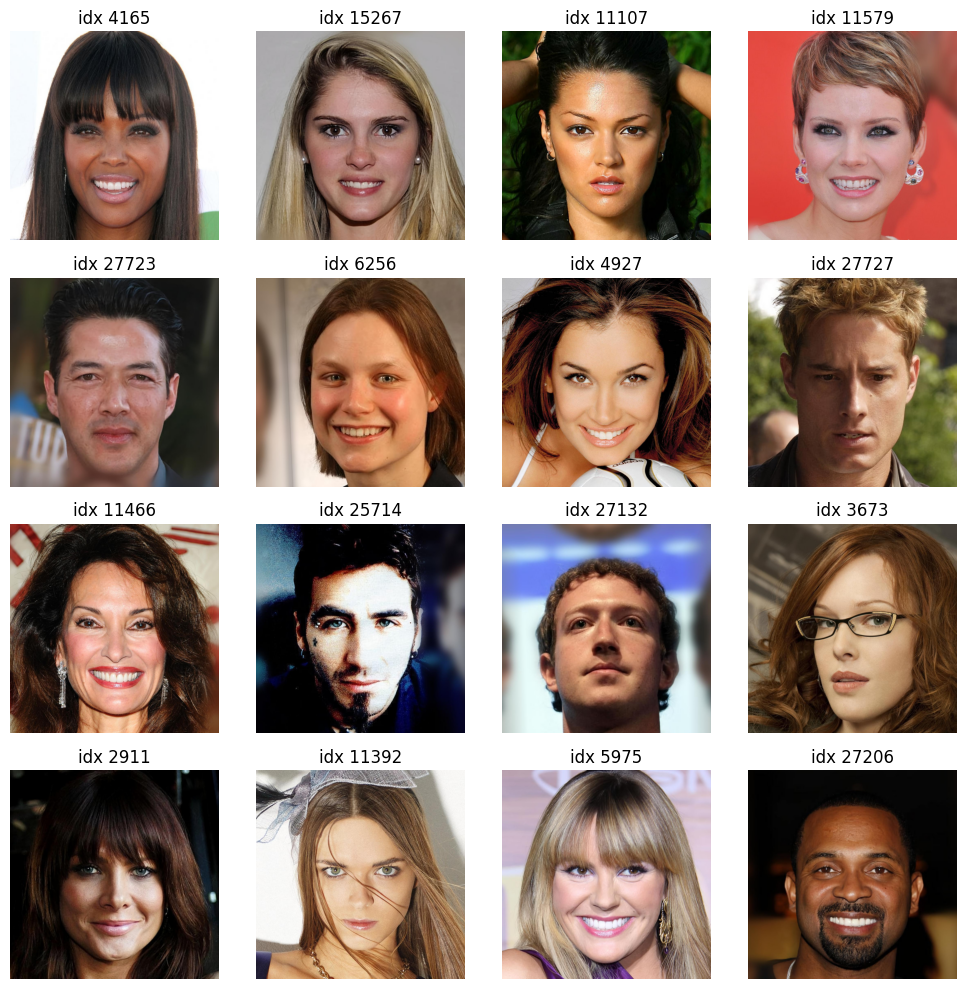

In [4]:
# Preview 16 samples from celebahq_dataset
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

if celebahq_dataset is None or len(celebahq_dataset) == 0:
    raise RuntimeError("celebahq_dataset is empty. Run the download cell first.")

n_show = min(16, len(celebahq_dataset))
idxs = random.sample(range(len(celebahq_dataset)), n_show) if len(celebahq_dataset) > 16 else list(range(n_show))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, idx in zip(axes.flatten(), idxs):
    sample = celebahq_dataset[idx]
    img = sample.get("image", sample)
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    elif not isinstance(img, Image.Image):
        raise TypeError(f"Unsupported image type: {type(img)}")
    ax.imshow(img)
    ax.set_title(f"idx {idx}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Load Pretrained Unconditional Latent Diffusion Model

Using `CompVis/ldm-celebahq-256`, an **unconditional** Latent Diffusion Model (LDM) trained on CelebA-HQ.

**LDM Architecture:**
- VAE: Image ↔ Latent Space
- UNet: Denoising in Latent Space (unconditional)

In [5]:
from diffusers import DiffusionPipeline

# Load Unconditional Latent Diffusion Model (LDM)
# This is a true unconditional model working in latent space
print("Loading Unconditional LDM (CompVis/ldm-celebahq-256)...")
print("This is an unconditional Latent Diffusion Model trained on CelebA-HQ")

ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
ldm_pipe = ldm_pipe.to("cuda")  # Use selected GPU

# Fix VQ-VAE scaling factor for proper image generation
# The default scaling_factor may cause color/brightness issues
ldm_pipe.vqvae.config.scaling_factor = 1.0

print("\n✓ Unconditional LDM loaded!")
print(f"  Model: CompVis/ldm-celebahq-256")
print(f"  Output size: 256×256")
print(f"  Latent Space: Yes (VAE)")
print(f"  VAE scaling factor: {ldm_pipe.vqvae.config.scaling_factor}")
print(f"  Generation: Pure unconditional, no condition input required")

Loading Unconditional LDM (CompVis/ldm-celebahq-256)...
This is an unconditional Latent Diffusion Model trained on CelebA-HQ


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/user/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/user/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
An error occurred while trying to fetch /home/user/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c3940e227c9714bdd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/user/.cache/huggingface/hub/models--CompVis--ldm-celebahq-256/snapshots/03978f22272a3c2502da709c39


✓ Unconditional LDM loaded!
  Model: CompVis/ldm-celebahq-256
  Output size: 256×256
  Latent Space: Yes (VAE)
  VAE scaling factor: 1.0
  Generation: Pure unconditional, no condition input required


## 3.1 Extract LDM's VAE

Directly use LDM's built-in VAE to maintain consistent latent space. The VAE is pre-trained as part of the LDM, so we demonstrate its reconstruction quality here before proceeding with image generation.

In [6]:
# Directly use LDM's built-in VAE
# This way KSWGD and LDM use exactly the same latent space

print("Extracting LDM's VAE...")

# LDM pipeline contains vqvae (VQ-VAE)
vae = ldm_pipe.vqvae
vae_scaling = 1.0  # LDM's VQ-VAE doesn't need extra scaling

print(f"\n✓ VAE extracted!")
print(f"  Source: LDM's built-in VQ-VAE")
print(f"  Scaling factor: {vae_scaling}")
print(f"  Advantage: KSWGD and LDM share the same latent space")

# VAE helper functions
def _to_vae_range(x):
    """[0,1] → [-1,1]"""
    return (x * 2.0) - 1.0

def _from_vae_range(x):
    """[-1,1] → [0,1]"""
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use selected GPU

Extracting LDM's VAE...

✓ VAE extracted!
  Source: LDM's built-in VQ-VAE
  Scaling factor: 1.0
  Advantage: KSWGD and LDM share the same latent space


=== VAE Reconstruction Quality Test ===

Dataset size: 28000 CelebA-HQ images
Test samples: 5
Sampling method: Random sampling
VAE source: LDM pretrained model built-in VQ-VAE
Test purpose: Validate VAE encode→decode reconstruction quality

Using pure random (no seed)
Randomly selected sample indices: [25706, 2047, 4649, 25144, 20200]


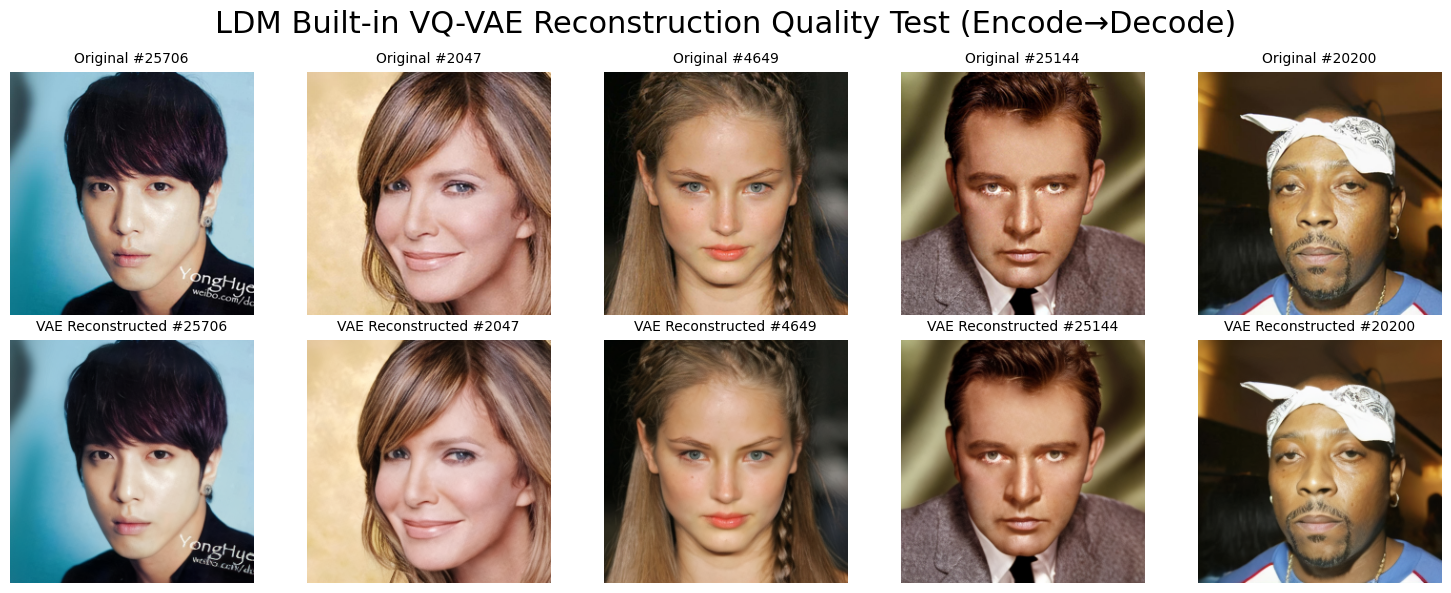

VAE reconstruction test completed.


In [7]:
# Test VAE reconstruction on real images
# 🔍 VAE Quality Test: Demonstrate LDM's built-in VQ-VAE reconstruction capability
# VAE Source: Built-in VQ-VAE from CompVis/ldm-celebahq-256 pretrained model

import random

# ============== Sampling Settings ==============
n_recon = 5
USE_RANDOM_SAMPLES = True  # True: random sampling, False: first n_recon samples
# RANDOM_SEED = 42  # Set random seed for reproducible results (comment out for pure random)
# ==============================================

print(f"=== VAE Reconstruction Quality Test ===\n")
print(f"Dataset size: {len(celebahq_dataset)} CelebA-HQ images")
print(f"Test samples: {n_recon}")
print(f"Sampling method: {'Random sampling' if USE_RANDOM_SAMPLES else 'First '+str(n_recon)+' samples'}")
print(f"VAE source: LDM pretrained model built-in VQ-VAE")
print(f"Test purpose: Validate VAE encode→decode reconstruction quality\n")

# Select test samples
if USE_RANDOM_SAMPLES:
    # Check if RANDOM_SEED is defined, if not use pure random
    if 'RANDOM_SEED' in locals():
        random.seed(RANDOM_SEED)
        print(f"Using random seed: {RANDOM_SEED}")
    else:
        print("Using pure random (no seed)")
    
    test_indices = random.sample(range(len(celebahq_dataset)), n_recon)
    print(f"Randomly selected sample indices: {test_indices}")
else:
    test_indices = list(range(n_recon))
    print(f"Fixed sample indices: {test_indices}")

fig, axes = plt.subplots(2, n_recon, figsize=(15, 6))

vae.eval()
with torch.no_grad():
    for plot_idx, sample_idx in enumerate(test_indices):
        # Original
        img = celebahq_dataset[sample_idx]["image"]
        img_tensor = T.Compose([T.Resize((256, 256)), T.ToTensor()])(img).unsqueeze(0).to(device)
        
        # Encode & Decode
        latent = vae.encode(_to_vae_range(img_tensor))
        
        if hasattr(latent, 'latents'):
            latent_code = latent.latents
        elif hasattr(latent, 'latent_dist'):
            latent_code = latent.latent_dist.mode()
        else:
            latent_code = latent[0] if isinstance(latent, tuple) else latent
            
        recon = vae.decode(latent_code).sample
        recon_img = _from_vae_range(recon).cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        # Plot
        axes[0, plot_idx].imshow(np.array(img.resize((256, 256))))
        axes[0, plot_idx].set_title(f"Original #{sample_idx}", fontsize=10)
        axes[0, plot_idx].axis('off')
        
        axes[1, plot_idx].imshow(recon_img)
        axes[1, plot_idx].set_title(f"VAE Reconstructed #{sample_idx}", fontsize=10)
        axes[1, plot_idx].axis('off')

plt.suptitle("LDM Built-in VQ-VAE Reconstruction Quality Test (Encode→Decode)", fontsize=22)
plt.tight_layout()
plt.show()

print("VAE reconstruction test completed.")

## 4. Super-Resolution Setup (Real-ESRGAN + GFPGAN)

Set up the upscaling pipeline. Actual LDM generation will happen **after KSWGD** to optimize memory usage.

In [8]:
# ============== Real-ESRGAN + GFPGAN Super-Resolution Setup ==============
import os
import cv2
import numpy as np
from PIL import Image
import sys
import types
import urllib.request
import torch

# Compatibility shim for basicsr expecting torchvision.transforms.functional_tensor
from torchvision.transforms import functional as TF
sys.modules['torchvision.transforms.functional_tensor'] = types.SimpleNamespace(rgb_to_grayscale=TF.rgb_to_grayscale)

from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from gfpgan import GFPGANer

# Create directories
os.makedirs('/workspace/kswgd/figures', exist_ok=True)
os.makedirs('/workspace/kswgd/gfpgan/weights', exist_ok=True)

def download_weight(path: str, urls: list, min_bytes: int = 1024 * 1024):
    """Download weight file from a list of mirror URLs, skip if already valid."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    # Check if file exists and is large enough
    if os.path.exists(path):
        try:
            size = os.path.getsize(path)
            if size >= min_bytes:
                # Try to load it to verify it's not corrupted
                torch.load(path, map_location='cpu', weights_only=False)
                print(f"Weights already valid: {path} ({size/1e6:.1f} MB)")
                return
        except Exception as e:
            print(f"Existing file corrupted, will redownload: {e}")
            os.remove(path)
    
    # Try each URL until one works
    for url in urls:
        try:
            print(f"Downloading from {url} ...")
            urllib.request.urlretrieve(url, path)
            # Verify
            torch.load(path, map_location='cpu', weights_only=False)
            print(f"  ✓ Download complete and verified")
            return
        except Exception as e:
            print(f"  ✗ Failed: {e}")
            if os.path.exists(path):
                os.remove(path)
            continue
    raise RuntimeError(f"Failed to download weights to {path} from any mirror")

# Real-ESRGAN weights - multiple mirrors
model_path = '/workspace/kswgd/weights/RealESRGAN_x4plus.pth'
realesrgan_urls = [
    'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth',
    'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x4plus.pth',
]
download_weight(model_path, realesrgan_urls, min_bytes=60_000_000)

# GFPGAN weights - multiple mirrors
gfpgan_path = '/workspace/kswgd/weights/GFPGANv1.3.pth'
gfpgan_urls = [
    'https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth',
    'https://github.com/TencentARC/GFPGAN/releases/download/v1.3.4/GFPGANv1.3.pth',
]
download_weight(gfpgan_path, gfpgan_urls, min_bytes=300_000_000)

# Facexlib detection model (retinaface) - needed by GFPGAN
detection_path = '/workspace/kswgd/gfpgan/weights/detection_Resnet50_Final.pth'
detection_urls = [
    'https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth',
    'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/detection_Resnet50_Final.pth',
]
download_weight(detection_path, detection_urls, min_bytes=100_000_000)

# Facexlib parsing model - needed by GFPGAN for face parsing
parsing_path = '/workspace/kswgd/gfpgan/weights/parsing_parsenet.pth'
parsing_urls = [
    'https://github.com/xinntao/facexlib/releases/download/v0.2.2/parsing_parsenet.pth',
    'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/parsing_parsenet.pth',
]
download_weight(parsing_path, parsing_urls, min_bytes=80_000_000)

print("\nInitializing Real-ESRGAN + GFPGAN...")
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
upsampler = RealESRGANer(
    scale=4,
    model_path=model_path,
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True,
    gpu_id=0
)
face_enhancer = GFPGANer(
    model_path=gfpgan_path,
    upscale=4,
    arch='clean',
    channel_multiplier=2,
    bg_upsampler=upsampler
)
print("  ✓ Real-ESRGAN + GFPGAN initialized")

def preprocess_image(img_bgr, use_gaussian=True, use_bilateral=True, use_color_norm=True):
    """Apply preprocessing before GFPGAN"""
    processed = img_bgr.copy().astype(np.float32)
    if use_gaussian:
        processed = cv2.GaussianBlur(processed, (3, 3), sigmaX=0.5)
    if use_bilateral:
        processed = cv2.bilateralFilter(processed.astype(np.uint8), d=5, sigmaColor=30, sigmaSpace=30).astype(np.float32)
    if use_color_norm:
        mean_b, mean_g, mean_r = np.mean(processed[:, :, 0]), np.mean(processed[:, :, 1]), np.mean(processed[:, :, 2])
        target_mean, alpha = 127.5, 0.3
        processed[:, :, 0] += alpha * (target_mean - mean_b)
        processed[:, :, 1] += alpha * (target_mean - mean_g)
        processed[:, :, 2] += alpha * (target_mean - mean_r)
        processed = np.clip(processed, 0, 255)
    return processed.astype(np.uint8)

def process_single_image(img, use_face_enhance=True, use_preprocess=True):
    """Process a single image"""
    if isinstance(img, Image.Image):
        img_np = np.array(img)
    else:
        if img.ndim == 3 and img.shape[0] == 3:
            img_np = np.transpose(img, (1, 2, 0))
        else:
            img_np = img
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)

    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    if use_preprocess:
        img_bgr = preprocess_image(img_bgr)

    if use_face_enhance:
        _, _, output_bgr = face_enhancer.enhance(img_bgr, has_aligned=False, only_center_face=False, paste_back=True)
    else:
        output_bgr, _ = upsampler.enhance(img_bgr, outscale=4)

    return cv2.cvtColor(output_bgr, cv2.COLOR_BGR2RGB)

def upscale_images(images_list, use_face_enhance=True, use_preprocess=True, desc="Upscaling"):
    outputs = []
    for img in tqdm(images_list, desc=desc):
        outputs.append(process_single_image(img, use_face_enhance=use_face_enhance, use_preprocess=use_preprocess))
    return outputs

Weights already valid: /workspace/kswgd/weights/RealESRGAN_x4plus.pth (67.0 MB)
Weights already valid: /workspace/kswgd/weights/GFPGANv1.3.pth (348.6 MB)
Weights already valid: /workspace/kswgd/gfpgan/weights/detection_Resnet50_Final.pth (109.5 MB)
Weights already valid: /workspace/kswgd/gfpgan/weights/parsing_parsenet.pth (85.3 MB)

Initializing Real-ESRGAN + GFPGAN...


/workspace/kswgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/kswgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  ✓ Real-ESRGAN + GFPGAN initialized


In [9]:
# Section 6.5: Memory Cleanup
# To avoid OOM during KSWGD, we release the LDM UNet and other components that are no longer needed.
import gc

print(f"GPU Memory before cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

if 'ldm_pipe' in globals():
    # We only need the VAE for KSWGD, so we can release the UNet (the largest part)
    # This can free up 2-4 GB of VRAM.
    print("Releasing LDM UNet and other components...")
    if hasattr(ldm_pipe, 'unet'):
        ldm_pipe.unet = None
    if hasattr(ldm_pipe, 'text_encoder'):
        ldm_pipe.text_encoder = None
    if hasattr(ldm_pipe, 'scheduler'):
        ldm_pipe.scheduler = None
    
gc.collect()
torch.cuda.empty_cache()

print(f"GPU Memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

GPU Memory before cleanup: 1.93 GB
Releasing LDM UNet and other components...
GPU Memory after cleanup: 0.82 GB


## 7. KSWGD Unconditional Generation (Core Experiment)

Using KSWGD (Koopman Spectral Wasserstein Gradient Descent) to perform **unconditional** particle transport generation in latent space.

**Unconditional Pipeline:**
```
Training Data (CelebA-HQ) → VAE Encoder → Latent Z_tar (Target Distribution Samples)
                                              ↓
Random Noise N(0,1) → KSWGD Transport → Z_gen (Unconditional Generation)
                                              ↓
                                   VAE Decoder → Generated Image
```

**Comparison of Two Unconditional Methods (Fair Comparison, Same Dataset):**
| | LDM (Section 2-4) | KSWGD (Section 7) |
|---|---|---|
| Dataset | CelebA-HQ | CelebA-HQ |
| Generation Process | Random Noise → Denoising | Random Noise → KSWGD |
| Core Component | UNet | Kernel Matrix + Eigendecomposition |
| Condition Input | None | None |
| Iteration Steps | 200 | Adjustable (e.g., 300) |

In [10]:
# Import KSWGD required libraries and custom kernel functions
from sklearn.metrics import pairwise_distances
from tqdm.auto import trange

# Import your kernel functions
from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

# Try to import GPU version
try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_KSWGD = True
    print("✓ GPU KSWGD backend available (CuPy)")
except Exception as e:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_KSWGD = False
    print(f"✗ GPU KSWGD backend not available: {e}")
    print("  Using CPU backend instead")



✓ GPU KSWGD backend available (CuPy)


In [11]:
# Encode CelebA-HQ images and compress with MLP AutoEncoder
from torchvision import transforms as T
from tqdm.auto import tqdm
import pickle
import os

# Image preprocessing
transform_celebahq = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

# ============== MLP Latent Compression Settings ==============
# Use MLP AutoEncoder to compress VAE's 1024-dim latent to lower dimension
REDUCED_DIM = 8  # Target dimension for MLP compression (optimized for background quality)
# =============================================================

# ============== Caching Settings ==============
LOAD_FROM_CACHE = True
CACHE_DIR = "/workspace/kswgd/cache"
os.makedirs(CACHE_DIR, exist_ok=True)
# ==============================================

# ============== MLP Latent AutoEncoder ==============
class LatentAutoEncoder(torch.nn.Module):
    """
    Deeper and wider MLP to compress VAE latent space (1024-dim) to lower dimension.
    Uses 5-layer encoder/decoder with hidden_dim=512 for better representation.
    """
    def __init__(self, input_dim=1024, latent_dim=64, hidden_dim=512):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder: 1024 -> 512 -> 512 -> 512 -> 256 -> latent_dim (5 layers, deeper)
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.LayerNorm(hidden_dim // 2),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim // 2, latent_dim),
        )
        
        # Decoder: latent_dim -> 256 -> 512 -> 512 -> 512 -> 1024 (5 layers, deeper)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim // 2),
            torch.nn.LayerNorm(hidden_dim // 2),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim // 2, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.LayerNorm(hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, input_dim),
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z), z


def train_latent_autoencoder(Z_flat, latent_dim=64, epochs=100, batch_size=512, lr=1e-3, use_perceptual_loss=True):
    """Train the MLP AutoEncoder on VAE latent codes with perceptual loss"""
    print(f"\n=== Training Latent AutoEncoder (1024 -> {latent_dim}) ===")
    print(f"  Loss: {'LPIPS Perceptual Loss + MSE' if use_perceptual_loss else 'MSE only'}")
    
    model = LatentAutoEncoder(input_dim=Z_flat.shape[1], latent_dim=latent_dim, hidden_dim=512).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # LPIPS perceptual loss (requires reshaping latent vectors to spatial format)
    lpips_loss_fn = None
    if use_perceptual_loss:
        try:
            import lpips
            lpips_loss_fn = lpips.LPIPS(net='vgg').to(device)
            lpips_loss_fn.eval()
            for param in lpips_loss_fn.parameters():
                param.requires_grad = False
            print("  ✓ LPIPS loss loaded (VGG-based)")
        except ImportError:
            print("  ⚠ lpips not installed, falling back to MSE. Install with: pip install lpips")
            use_perceptual_loss = False
    
    # Convert to tensor
    Z_tensor = torch.from_numpy(Z_flat).float().to(device)
    dataset = torch.utils.data.TensorDataset(Z_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    best_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0.0
        total_mse = 0.0
        total_lpips = 0.0
        
        for (batch,) in dataloader:
            optimizer.zero_grad()
            recon, z = model(batch)
            
            # MSE loss (always computed)
            mse_loss = torch.nn.functional.mse_loss(recon, batch)
            
            # Perceptual loss (LPIPS on reshaped features)
            if use_perceptual_loss and lpips_loss_fn is not None:
                # Reshape latent vectors to spatial format for LPIPS: (B, 1024) -> (B, 4, 16, 16)
                batch_spatial = batch.view(-1, 4, 16, 16)
                recon_spatial = recon.view(-1, 4, 16, 16)
                
                # LPIPS expects 3-channel input, so we replicate channels: (B, 4, 16, 16) -> (B, 3, 16, 16)
                # Take first 3 channels
                batch_3ch = batch_spatial[:, :3, :, :]
                recon_3ch = recon_spatial[:, :3, :, :]
                
                # Normalize to [-1, 1] range (LPIPS expects this)
                batch_norm = 2.0 * (batch_3ch - batch_3ch.min()) / (batch_3ch.max() - batch_3ch.min() + 1e-8) - 1.0
                recon_norm = 2.0 * (recon_3ch - recon_3ch.min()) / (recon_3ch.max() - recon_3ch.min() + 1e-8) - 1.0
                
                lpips_loss = lpips_loss_fn(batch_norm, recon_norm).mean()
                
                # Combined loss: MSE + 0.7 * LPIPS (higher weight on perceptual quality)
                loss = mse_loss + 0.7 * lpips_loss
                total_lpips += lpips_loss.item() * batch.size(0)
            else:
                loss = mse_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.size(0)
            total_mse += mse_loss.item() * batch.size(0)
        
        avg_loss = total_loss / len(Z_tensor)
        avg_mse = total_mse / len(Z_tensor)
        avg_lpips = total_lpips / len(Z_tensor) if use_perceptual_loss else 0.0
        scheduler.step()
        
        if avg_loss < best_loss:
            best_loss = avg_loss
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            if use_perceptual_loss:
                print(f"  Epoch {epoch+1:3d}/{epochs}: Total={avg_loss:.6f}, MSE={avg_mse:.6f}, LPIPS={avg_lpips:.6f}")
            else:
                print(f"  Epoch {epoch+1:3d}/{epochs}: Loss = {avg_loss:.6f}")
    
    print(f"✓ Training complete! Best loss: {best_loss:.6f}")
    
    # Encode all data
    model.eval()
    with torch.no_grad():
        Z_reduced = model.encode(Z_tensor).cpu().numpy()
    
    return model, Z_reduced
# ====================================================

max_samples = 28000

# Generate cache filename
cache_path = os.path.join(CACHE_DIR, f"vae_encoding_n{max_samples}_mlp{REDUCED_DIM}.pkl")

loaded_from_cache = False

# Try to load from cache (with corruption handling)
if LOAD_FROM_CACHE and os.path.exists(cache_path):
    print(f"Loading VAE encodings from cache: {cache_path}")
    try:
        with open(cache_path, 'rb') as f:
            cache_data = pickle.load(f)
    except (pickle.UnpicklingError, EOFError) as e:
        print(f"⚠ Cache file corrupted ({e}); deleting and recomputing.")
        try:
            os.remove(cache_path)
            print("  Corrupted cache removed.")
        except OSError as rm_err:
            print(f"  Could not remove cache: {rm_err}")
    else:
        Z_all = cache_data['Z_all']
        latent_dim = cache_data['latent_dim']
        full_latent_shape = cache_data['full_latent_shape']
        latent_ae = cache_data.get('latent_ae')
        loaded_from_cache = True
        
        print(f"✓ Loaded from cache!")
        print(f"  Z_all shape: {Z_all.shape}")
        print(f"  Latent dim: {latent_dim}")

if not loaded_from_cache:
    print(f"Cache not found or disabled. Computing VAE encodings...")
    
    all_latents = []
    vae.eval()
    print(f"Encoding {max_samples} images to latent space...")

    with torch.no_grad():
        for i in tqdm(range(min(max_samples, len(celebahq_dataset))), desc="Encoding"):
            img = celebahq_dataset[i]["image"]
            img_tensor = transform_celebahq(img).unsqueeze(0).to(device)
            
            # Encode to latent
            latent = vae.encode(_to_vae_range(img_tensor))
            latent_code = latent.latents if hasattr(latent, 'latents') else (latent.latent_dist.mode() if hasattr(latent, 'latent_dist') else latent[0])
            latent_code = latent_code * vae_scaling  # (1, 4, 16, 16)
            
            all_latents.append(latent_code.view(1, -1).cpu().numpy())

    Z_flat = np.concatenate(all_latents, axis=0)
    print(f"Latent vectors collected: {Z_flat.shape}")
    
    # ============== Train MLP AutoEncoder ==============
    import time as _time
    print(f"\n Training MLP AutoEncoder (1024 -> {REDUCED_DIM})...")
    _mlp_start = _time.time()
    
    # Train the autoencoder
    latent_ae, Z_all = train_latent_autoencoder(
        Z_flat, 
        latent_dim=REDUCED_DIM, 
        epochs=150,  # Increased for better convergence
        batch_size=512,
        lr=1e-3
    )
    latent_dim = Z_all.shape[1]
    
    _mlp_elapsed = _time.time() - _mlp_start
    print(f"\n✓ MLP AutoEncoder complete! Time: {_mlp_elapsed:.2f}s")
    print(f"  Original VAE latent: {Z_flat.shape[1]} dim (4×16×16)")
    print(f"  Compressed latent:   {Z_all.shape[1]} dim")
    
    # Test reconstruction quality
    with torch.no_grad():
        Z_test = torch.from_numpy(Z_flat[:100]).float().to(device)
        Z_recon, _ = latent_ae(Z_test)
        recon_loss = torch.nn.functional.mse_loss(Z_recon, Z_test).item()
        print(f"  Reconstruction MSE (test): {recon_loss:.6f}")

    # Record shapes for decoding
    with torch.no_grad():
        dummy = torch.zeros(1, 3, 256, 256, device=device)
        dummy_latent = vae.encode(_to_vae_range(dummy))
        dummy_code = dummy_latent.latents if hasattr(dummy_latent, 'latents') else (dummy_latent.latent_dist.mode() if hasattr(dummy_latent, 'latent_dist') else dummy_latent[0])
        full_latent_shape = dummy_code.shape[1:]  # (4, 16, 16)

    # Save to cache
    print(f"\nSaving to cache: {cache_path}")
    cache_data = {
        'Z_all': Z_all,
        'latent_dim': latent_dim,
        'latent_ae': latent_ae,
        'full_latent_shape': full_latent_shape,
        'REDUCED_DIM': REDUCED_DIM,
        'max_samples': max_samples
    }
    with open(cache_path, 'wb') as f:
        pickle.dump(cache_data, f)
    print(f"✓ Cache saved!")

print(f"Full Latent Shape: {full_latent_shape}")

Loading VAE encodings from cache: /workspace/kswgd/cache/vae_encoding_n28000_mlp8.pkl
✓ Loaded from cache!
  Z_all shape: (28000, 8)
  Latent dim: 8
Full Latent Shape: torch.Size([3, 64, 64])


### 7.1 Latent Space Compression with MLP AutoEncoder

We use a **learnable MLP AutoEncoder** to compress the VQ-VAE latent space from 1024 (4×16×16) to 64 dimensions.

**Architecture:**
```
VAE Latent (1024) → MLP Encoder → Compressed (64) → MLP Decoder → VAE Latent (1024)
```

In [12]:
# Standardize latent codes and build KSWGD kernel operator
# Standardization
Z_mean = np.mean(Z_all, axis=0, keepdims=True)
Z_std = np.std(Z_all, axis=0, keepdims=True) + 1e-8
Z_std = Z_std.astype(np.float64)
Z_mean = Z_mean.astype(np.float64)
X_tar = ((Z_all - Z_mean) / Z_std).astype(np.float64)

print(f"After standardization: mean={X_tar.mean():.4f}, std={X_tar.std():.4f}")

# Compute squared sum of target samples (for kernel function)
sq_tar = np.sum(X_tar ** 2, axis=1)

# Compute pairwise distances and bandwidth epsilon
dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))

print(f"KSWGD epsilon: {eps_kswgd:.6f}")
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Build data kernel matrix
data_kernel = np.exp(-dists**2 / (2.0 * eps_kswgd))

# Normalization
p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
rw_kernel = np.nan_to_num(rw_kernel)

print(f"Kernel matrix built, shape: {rw_kernel.shape}")

# latent_dim is already set in the previous cell (Spatial Mean Pooling)
print(f"KSWGD latent_dim: {latent_dim}")

After standardization: mean=-0.0000, std=1.0000
KSWGD epsilon: 0.761092
Distance stats: min=0.0000, median=3.9481, max=7.0672
Kernel matrix built, shape: (28000, 28000)
KSWGD latent_dim: 8


In [13]:
# Compute eigendecomposition and KSWGD weights
import time
import threading
from scipy.sparse.linalg import eigsh

print("Computing eigendecomposition...")
start_time = time.time()

# ============== Truncated Eigendecomposition Settings ==============
# k: number of largest eigenvalues to compute
# Using truncated decomposition is much faster for large matrices (e.g., 30000x30000)
k_eig = 50  # Default: compute top 300 eigenvalues (truncated)
# k_eig = rw_kernel.shape[0]  # Uncomment this line to compute ALL eigenvalues (full decomposition)
USE_GPU_EIGSH = True  # Use GPU for truncated eigendecomposition (torch.lobpcg)
# ===================================================================

n_samples = rw_kernel.shape[0]
use_truncated = k_eig < n_samples

# Estimate time based on matrix size
if use_truncated:
    est_time = n_samples * k_eig / 1e7  # Rough estimate for truncated
else:
    est_time = (n_samples ** 2.5) / 1e9  # O(n^3) but optimized

# Progress tracking with elapsed time display
_eig_done = threading.Event()
_eig_result = {}

def _show_progress():
    """Show elapsed time while eigendecomposition is running"""
    import sys
    symbols = ['⠋', '⠙', '⠹', '⠸', '⠼', '⠴', '⠦', '⠧', '⠇', '⠏']
    idx = 0
    while not _eig_done.is_set():
        elapsed = time.time() - start_time
        sys.stdout.write(f"\r  {symbols[idx]} Eigendecomposition in progress... {elapsed:.1f}s elapsed")
        sys.stdout.flush()
        idx = (idx + 1) % len(symbols)
        _eig_done.wait(0.2)
    sys.stdout.write("\r" + " " * 60 + "\r")  # Clear line
    sys.stdout.flush()

def _run_eigsh_cpu():
    """Run truncated eigendecomposition on CPU (scipy)"""
    lambda_ns_partial, phi_partial = eigsh(rw_kernel, k=k_eig, which='LM')
    _eig_result['lambda'] = lambda_ns_partial
    _eig_result['phi'] = phi_partial
    _eig_done.set()

def _run_eigsh_gpu():
    """Run truncated eigendecomposition on GPU (torch.lobpcg)"""
    # torch.lobpcg computes largest eigenvalues of symmetric positive definite matrices
    rw_kernel_torch = torch.from_numpy(rw_kernel).float().to(device)
    
    # Random initial vectors for lobpcg
    X0 = torch.randn(n_samples, k_eig, device=device, dtype=torch.float32)
    
    # lobpcg for largest eigenvalues (works well for positive semi-definite matrices)
    try:
        eigenvalues, eigenvectors = torch.lobpcg(rw_kernel_torch, k=k_eig, X=X0, largest=True, niter=100)
        _eig_result['lambda'] = eigenvalues.cpu().numpy()
        _eig_result['phi'] = eigenvectors.cpu().numpy()
    except Exception as e:
        print(f"\n  Warning: GPU lobpcg failed ({e}), falling back to CPU...")
        _eig_done.set()
        return False
    
    del rw_kernel_torch, X0, eigenvalues, eigenvectors
    torch.cuda.empty_cache()
    _eig_done.set()
    return True

def _run_eigh_gpu():
    """Run full eigendecomposition on GPU"""
    rw_kernel_torch = torch.from_numpy(rw_kernel).to(device)
    lambda_ns_torch, phi_torch = torch.linalg.eigh(rw_kernel_torch)
    _eig_result['lambda'] = lambda_ns_torch.cpu().numpy()[::-1].copy()
    _eig_result['phi'] = phi_torch.cpu().numpy()[:, ::-1].copy()
    del rw_kernel_torch, lambda_ns_torch, phi_torch
    torch.cuda.empty_cache()
    _eig_done.set()

def _run_eigh_cpu():
    """Run full eigendecomposition on CPU"""
    lambda_ns_raw, phi_raw = np.linalg.eigh(rw_kernel)
    _eig_result['lambda'] = lambda_ns_raw[::-1]
    _eig_result['phi'] = phi_raw[:, ::-1]
    _eig_done.set()

if use_truncated:
    print(f"  Using TRUNCATED eigendecomposition (top {k_eig} of {n_samples})...")
    
    # Try GPU first if enabled
    use_gpu_eig = USE_GPU_EIGSH and torch.cuda.is_available()
    
    if use_gpu_eig:
        print(f"  Backend: PyTorch GPU (torch.lobpcg)")
        print(f"  Estimated time: ~{est_time/5:.0f}-{est_time:.0f} seconds (GPU accelerated)")
        
        # Start progress display thread
        progress_thread = threading.Thread(target=_show_progress, daemon=True)
        progress_thread.start()
        
        # Try GPU lobpcg
        gpu_success = _run_eigsh_gpu()
        progress_thread.join(timeout=1)
        
        if not gpu_success or 'lambda' not in _eig_result:
            # Fallback to CPU
            print(f"  Falling back to CPU (scipy.sparse.linalg.eigsh)...")
            _eig_done.clear()
            _eig_result.clear()
            start_time = time.time()  # Reset timer
            progress_thread = threading.Thread(target=_show_progress, daemon=True)
            progress_thread.start()
            _run_eigsh_cpu()
            progress_thread.join(timeout=1)
    else:
        print(f"  Backend: CPU (scipy.sparse.linalg.eigsh)")
        print(f"  Estimated time: ~{est_time:.0f}-{est_time*2:.0f} seconds")
        
        # Start progress display thread
        progress_thread = threading.Thread(target=_show_progress, daemon=True)
        progress_thread.start()
        
        # Run CPU eigendecomposition
        _run_eigsh_cpu()
        progress_thread.join(timeout=1)
    
    # Sort in descending order
    sort_idx = np.argsort(_eig_result['lambda'])[::-1]
    lambda_ns = _eig_result['lambda'][sort_idx]
    phi = _eig_result['phi'][:, sort_idx]
else:
    print(f"  Using FULL eigendecomposition ({n_samples} x {n_samples})...")
    print(f"  Estimated time: ~{est_time:.0f}-{est_time*3:.0f} seconds")
    
    # Start progress display thread
    progress_thread = threading.Thread(target=_show_progress, daemon=True)
    progress_thread.start()
    
    if torch.cuda.is_available():
        print("    Using GPU acceleration...")
        _run_eigh_gpu()
    else:
        print("    Using CPU...")
        _run_eigh_cpu()
    
    progress_thread.join(timeout=1)
    lambda_ns = _eig_result['lambda']
    phi = _eig_result['phi']

elapsed = time.time() - start_time
print(f"✓ Eigendecomposition complete! Time: {elapsed:.1f}s")

# Set regularization parameters
tol = 1e-6
reg = 1e-3
latent_dim = X_tar.shape[1]

# Compute inverse eigenvalues (fix negative number issue)
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
# Only compute inverse for positive lambda_, set negative to 0
positive_mask = lambda_[1:] > tol
inv_lambda[1:][positive_mask] = 1.0 / (np.abs(lambda_[1:][positive_mask]) + reg)
inv_lambda *= eps_kswgd

# Count eigenvalues above tolerance (always compute this regardless of truncation)
above_tol = int(np.sum(lambda_ns >= tol))

# Truncate small eigenvalues
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

# Clean NaN and Inf
lambda_ns_s_ns = np.nan_to_num(lambda_ns_s_ns, nan=0.0, posinf=0.0, neginf=0.0)

# Target distribution weights
p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

print(f"\n✓ Eigendecomposition Summary:")
print(f"  Matrix size: {n_samples} x {n_samples}")
print(f"  Computed eigenvalues: {len(lambda_ns)} ({'truncated' if use_truncated else 'full'})")
print(f"  Eigenvalues >= {tol}: {above_tol}")
print(f"  Retained eigenvectors: {above_tol}")
print(f"  Top 10 eigenvalues: {lambda_ns[:10]}")
print(f"  lambda_ns_s_ns stats: min={lambda_ns_s_ns.min():.6f}, max={lambda_ns_s_ns.max():.6f}, non-zero={np.sum(lambda_ns_s_ns != 0)}")

Computing eigendecomposition...
  Using TRUNCATED eigendecomposition (top 50 of 28000)...
  Backend: PyTorch GPU (torch.lobpcg)
  Estimated time: ~0-0 seconds (GPU accelerated)
✓ Eigendecomposition complete! Time: 1.6s                   

✓ Eigendecomposition Summary:
  Matrix size: 28000 x 28000
  Computed eigenvalues: 50 (truncated)
  Eigenvalues >= 1e-06: 50
  Retained eigenvectors: 50
  Top 10 eigenvalues: [1.0027077  0.81892127 0.78783745 0.7713865  0.76128453 0.7230653
 0.66801584 0.6504554  0.6121424  0.60449344]
  lambda_ns_s_ns stats: min=0.000000, max=0.000000, non-zero=0


### 6.2 EDMD Dictionary Learning for True Koopman Operator (KSWGD)

The previous cell computed the **Diffusion Map** spectral decomposition (DMPS method).
Now we implement the **true KSWGD** using EDMD (Extended Dynamic Mode Decomposition):

1. **KDE-based drift estimation**: Estimate the score function $\nabla \log p(x)$ using kernel density estimation
2. **Langevin evolution**: Generate time-series pairs $(X_t, X_{t+\Delta t})$ via Langevin dynamics
3. **Dictionary learning**: Learn a sparse dictionary on the latent space
4. **EDMD operator**: Build the Koopman operator in dictionary space

| Method | Basis Functions | Dynamics |
|--------|----------------|----------|
| DMPS | Diffusion map eigenvectors | Static kernel |
| KSWGD (EDMD) | Dictionary + Koopman eigenfunctions | Learned Langevin dynamics |

In [14]:
# KDE-based drift estimation and Langevin evolution to build EDMD pairs
from sklearn.decomposition import MiniBatchDictionaryLearning
from scipy.linalg import eig

print("=== EDMD Pipeline for True Koopman KSWGD ===")

# Step 1: KDE-based score function estimation
dt_edmd = 0.1  # time step for EDMD Langevin evolution
dist2_edmd = pairwise_distances(X_tar, metric="sqeuclidean")  # squared distances
h_edmd = np.sqrt(np.median(dist2_edmd) + 1e-12)  # KDE bandwidth
W_edmd = np.exp(-dist2_edmd / (2.0 * (h_edmd ** 2)))
sumW_edmd = np.sum(W_edmd, axis=1, keepdims=True) + 1e-12
weighted_means_edmd = W_edmd @ X_tar / sumW_edmd
score_edmd = (weighted_means_edmd - X_tar) / (h_edmd ** 2)  # KDE score = drift term

# Step 2: Langevin step to generate (X_t, X_{t+dt}) pairs
xi_edmd = np.random.normal(0.0, 1.0, size=X_tar.shape)
X_tar_next = X_tar + dt_edmd * score_edmd + np.sqrt(2.0 * dt_edmd) * xi_edmd

print(f"EDMD drift bandwidth h: {h_edmd:.4f}")
print(f"X_tar stats -> mean {X_tar.mean():.4f}, std {X_tar.std():.4f}")
print(f"X_tar_next stats -> mean {X_tar_next.mean():.4f}, std {X_tar_next.std():.4f}")

=== EDMD Pipeline for True Koopman KSWGD ===
EDMD drift bandwidth h: 3.9481
X_tar stats -> mean -0.0000, std 1.0000
X_tar_next stats -> mean -0.0014, std 1.0894


In [15]:
# Step 3: Dictionary learning on latent space
# Rule of thumb: dictionary size = 3-6x latent_dim, with N/m > 50 to avoid overfitting
# For N=30000, d=64: recommended m = 300-500 (gives N/m = 60-100)
n_dict_components = 50  # Dictionary atoms (total basis = n_dict_components + 1 for constant)
dict_alpha = 1e-3  # Sparsity penalty
dict_batch = 256
dict_max_iter = 500
dict_random_state = 42

print(f"\n=== Dictionary Learning ===")
print(f"Data: N={X_tar.shape[0]} samples, d={X_tar.shape[1]} dimensions")
print(f"Dictionary: {n_dict_components} atoms → {n_dict_components + 1} total basis functions")
print(f"Oversampling ratio: N/m = {X_tar.shape[0] / (n_dict_components + 1):.1f}x (recommended > 50)")
print(f"Learning dictionary...")

dict_model = MiniBatchDictionaryLearning(
    n_components=n_dict_components,
    alpha=dict_alpha,
    batch_size=dict_batch,
    max_iter=dict_max_iter,
    random_state=dict_random_state,
    verbose=0,
    fit_algorithm="lars"
)
dict_model.fit(X_tar)

# Transform to dictionary space and add constant term
Phi_X = dict_model.transform(X_tar)
Phi_Y = dict_model.transform(X_tar_next)
Phi_X = np.hstack([np.ones((Phi_X.shape[0], 1)), Phi_X])  # Add constant basis
Phi_Y = np.hstack([np.ones((Phi_Y.shape[0], 1)), Phi_Y])

print(f"Dictionary atoms shape: {dict_model.components_.shape}")
print(f"Dictionary codes (current) Phi_X: {Phi_X.shape}")
print(f"Dictionary codes (next) Phi_Y: {Phi_Y.shape}")


=== Dictionary Learning ===
Data: N=28000 samples, d=8 dimensions
Dictionary: 50 atoms → 51 total basis functions
Oversampling ratio: N/m = 549.0x (recommended > 50)
Learning dictionary...
Dictionary atoms shape: (50, 8)
Dictionary codes (current) Phi_X: (28000, 51)
Dictionary codes (next) Phi_Y: (28000, 51)


In [16]:
# Step 4: Build EDMD Koopman operator in dictionary space
print("\n=== EDMD Koopman Operator ===")

reg_edmd = 1e-3
N_edmd, m_edmd = Phi_X.shape

# EDMD: K = (Phi_X^T Phi_X + reg*I)^{-1} Phi_X^T Phi_Y
G_edmd = (Phi_X.T @ Phi_X) / N_edmd + reg_edmd * np.eye(m_edmd)
A_edmd = (Phi_X.T @ Phi_Y) / N_edmd

# Generalized eigenvalue problem: A v = lambda G v
eigvals_edmd, eigvecs_edmd = eig(A_edmd, G_edmd)
idx_edmd = np.argsort(-eigvals_edmd.real)
eigvals_edmd = eigvals_edmd[idx_edmd]
eigvecs_edmd = eigvecs_edmd[:, idx_edmd]

# Koopman eigenfunctions evaluated at data points
efuns_edmd = Phi_X @ eigvecs_edmd

print(f"EDMD eigenvalues (first 10): {np.round(eigvals_edmd[:10].real, 4)}")
print(f"EDMD eigenfunctions shape: {efuns_edmd.shape}")


=== EDMD Koopman Operator ===
EDMD eigenvalues (first 10): [0.999  0.8544 0.8398 0.813  0.7959 0.7553 0.7332 0.6725 0.6626 0.5894]
EDMD eigenfunctions shape: (28000, 51)


In [17]:
# Step 5: Prepare EDMD-derived KSWGD weights (skip constant mode)
print("\n=== Prepare EDMD-KSWGD Spectral Weights ===")

lambda_ns_edmd = eigvals_edmd.real
lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt_edmd  # Generator eigenvalues

mode_skip_edmd = 1  # Skip the constant eigenfunction (eigenvalue ~ 1)
eig_threshold_edmd = 1e-6  # Keep modes with eigenvalue > threshold

valid_idx_edmd = np.arange(mode_skip_edmd, lambda_ns_edmd.shape[0])
valid_mask_edmd = lambda_ns_edmd[mode_skip_edmd:] > eig_threshold_edmd
valid_idx_edmd = valid_idx_edmd[valid_mask_edmd]

if valid_idx_edmd.size == 0:
    raise RuntimeError("No EDMD modes survived the threshold; adjust eig_threshold_edmd or dictionary size.")

# Truncated Koopman eigenfunctions for KSWGD
phi_trunc_edmd = np.real(efuns_edmd[:, valid_idx_edmd])

# Generator inverse weights
lambda_gen_inv_edmd = np.zeros_like(lambda_gen_edmd)
mask_nonzero_edmd = np.abs(lambda_gen_edmd) > 1e-6
lambda_gen_inv_edmd[mask_nonzero_edmd] = 1.0 / lambda_gen_edmd[mask_nonzero_edmd]
lambda_ns_s_ns_edmd = lambda_gen_inv_edmd[valid_idx_edmd].real

print(f"EDMD kept {valid_idx_edmd.size} Koopman modes (threshold {eig_threshold_edmd})")
print(f"phi_trunc_edmd shape: {phi_trunc_edmd.shape}")
print(f"lambda_ns_s_ns_edmd stats: min={lambda_ns_s_ns_edmd.min():.6f}, max={lambda_ns_s_ns_edmd.max():.6f}")


=== Prepare EDMD-KSWGD Spectral Weights ===
EDMD kept 50 Koopman modes (threshold 1e-06)
phi_trunc_edmd shape: (28000, 50)
lambda_ns_s_ns_edmd stats: min=-0.686754, max=-0.124700


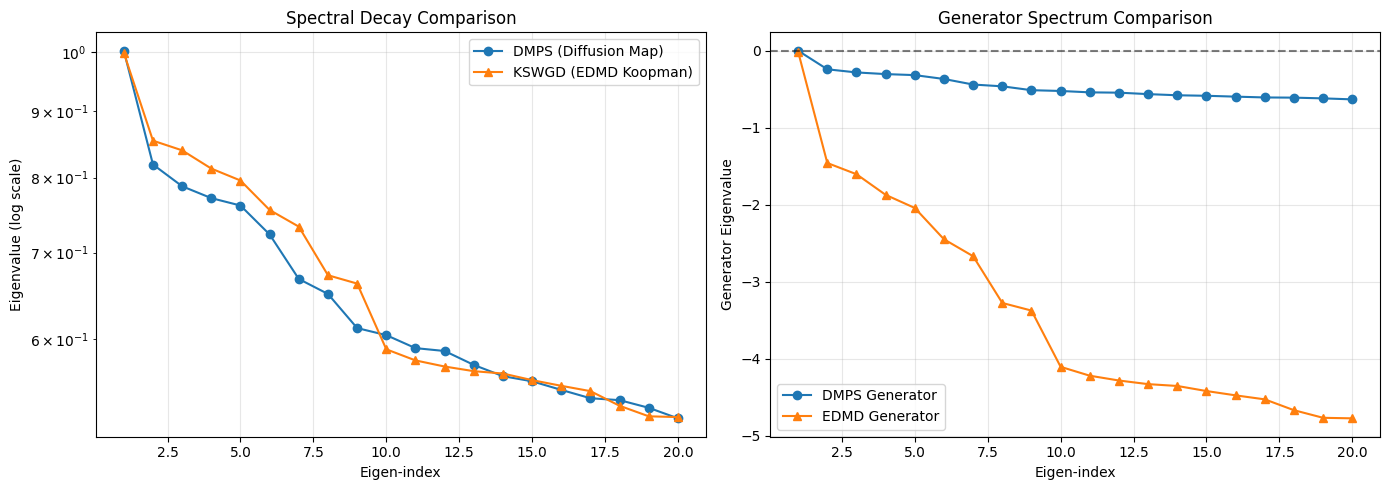


=== Method Comparison ===
DMPS: 50 diffusion map modes
KSWGD: 50 Koopman modes from EDMD


In [18]:
# Compare Diffusion Map (DMPS) and EDMD (KSWGD) spectra
import matplotlib.pyplot as plt

n_show_eigs = 20
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Eigenvalue comparison
ax1 = axes[0]
ax1.semilogy(range(1, n_show_eigs + 1), lambda_ns[:n_show_eigs], 'o-', label="DMPS (Diffusion Map)", markersize=6)
ax1.semilogy(range(1, min(n_show_eigs, lambda_ns_edmd.size) + 1), 
             lambda_ns_edmd[:n_show_eigs], '^-', label="KSWGD (EDMD Koopman)", markersize=6)
ax1.set_xlabel("Eigen-index")
ax1.set_ylabel("Eigenvalue (log scale)")
ax1.set_title("Spectral Decay Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Generator eigenvalues
ax2 = axes[1]
lambda_gen_dmps = (lambda_ns[:n_show_eigs] - 1.0) / eps_kswgd
ax2.plot(range(1, n_show_eigs + 1), lambda_gen_dmps, 'o-', label="DMPS Generator", markersize=6)
ax2.plot(range(1, min(n_show_eigs, lambda_gen_edmd.size) + 1), 
         lambda_gen_edmd[:n_show_eigs], '^-', label="EDMD Generator", markersize=6)
ax2.set_xlabel("Eigen-index")
ax2.set_ylabel("Generator Eigenvalue")
ax2.set_title("Generator Spectrum Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
# plt.savefig("figures/dmps_vs_kswgd_spectrum.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Method Comparison ===")
print(f"DMPS: {above_tol} diffusion map modes")
print(f"KSWGD: {valid_idx_edmd.size} Koopman modes from EDMD")

In [19]:
# Define unified sampler supporting both DMPS and KSWGD (EDMD) methods
def run_particle_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=42, method="dmps"):
    """
    Unified Particle Transport Sampler
    
    Parameters:
    -----------
    method : str
        "dmps" - Diffusion Map Particle Sampling (uses diffusion map eigenvectors)
        "kswgd" - True KSWGD with EDMD Koopman operator
    """
    rng = np.random.default_rng(rng_seed)
    use_gpu = GPU_KSWGD and torch.cuda.is_available()
    xp = cp if use_gpu else np
    grad_fn = grad_ker1_gpu if use_gpu else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu else K_tar_eval
    
    method = method.lower()
    if method == "dmps":
        method_name = "DMPS (Diffusion Map)"
        phi_use = phi_trunc
        lambda_use = lambda_ns_s_ns
    elif method == "kswgd":
        method_name = "KSWGD (EDMD Koopman)"
        phi_use = phi_trunc_edmd
        lambda_use = lambda_ns_s_ns_edmd
    else:
        raise ValueError(f"Unknown method: {method}. Use 'dmps' or 'kswgd'.")
    
    print(f"Method: {method_name}")
    print(f"Backend: {'GPU (CuPy)' if use_gpu else 'CPU (NumPy)'}")
    print(f"Eigenfunctions shape: {phi_use.shape}")
    
    x_hist = xp.zeros((num_particles, latent_dim, num_iters), dtype=xp.float64)
    init_particles = rng.normal(0.0, 1.0, size=(num_particles, latent_dim))
    x_hist[:, :, 0] = xp.asarray(init_particles)
    
    if use_gpu:
        X_tar_dev = cp.asarray(X_tar)
        p_tar_dev = cp.asarray(p_tar)
        sq_tar_dev = cp.asarray(sq_tar)
        D_vec_dev = cp.asarray(D_vec)
        phi_dev = cp.asarray(phi_use)
        lambda_dev = cp.asarray(lambda_use)
    else:
        X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev = X_tar, p_tar, sq_tar, D_vec
        phi_dev, lambda_dev = phi_use, lambda_use
    
    iterator = trange(num_iters - 1, desc=f"{method.upper()} Transport", unit="step")
    for t in iterator:
        current = x_hist[:, :, t]
        grad_matrix = grad_fn(current, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        cross_matrix = K_eval_fn(X_tar_dev, current, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        
        tmp = (phi_dev.T @ cross_matrix) * lambda_dev[:, None]
        push = phi_dev @ tmp
        
        for dim in range(latent_dim):
            sum_term = grad_matrix[:, :, dim] @ push
            x_hist[:, dim, t + 1] = x_hist[:, dim, t] - (step_size / num_particles) * xp.sum(sum_term, axis=1)
        
        if (t + 1) % 50 == 0:
            step_norm = x_hist[:, :, t + 1] - x_hist[:, :, t]
            mean_disp = float(xp.mean(xp.linalg.norm(step_norm, axis=1)))
            iterator.set_postfix({"mean_step": f"{mean_disp:.3e}"})
            if bool(xp.any(xp.isnan(x_hist[:, :, t + 1]))):
                print(f"\nWarning: NaN detected at step {t+1}")
                return np.asarray(xp.asnumpy(x_hist[:, :, t]) if use_gpu else x_hist[:, :, t], dtype=np.float64)
    
    return np.asarray(xp.asnumpy(x_hist[:, :, -1]) if use_gpu else x_hist[:, :, -1], dtype=np.float64)


# Backward compatibility alias
def run_kswgd_sampler(num_particles=16, num_iters=200, step_size=0.05, rng_seed=42):
    """Legacy wrapper - uses KSWGD by default for backward compatibility"""
    return run_particle_sampler(num_particles, num_iters, step_size, rng_seed, method="kswgd")


def decode_latents_to_images(flat_latents_std):
    """Decode standardized latent vectors to images using MLP AutoEncoder"""
    # 1. De-standardize
    flat_latents = flat_latents_std * Z_std + Z_mean
    
    # 2. MLP AutoEncoder decode (64-dim -> 1024-dim)
    latent_ae.eval()
    with torch.no_grad():
        flat_tensor = torch.from_numpy(flat_latents).float().to(device)
        latents_recovered = latent_ae.decode(flat_tensor).cpu().numpy()
    
    # 3. Reshape to (N, 4, 16, 16)
    latents_tensor = torch.from_numpy(latents_recovered).float().view(-1, *full_latent_shape).to(device)
    
    # 4. VAE decode
    vae.eval()
    with torch.no_grad():
        decoded = vae.decode(latents_tensor / vae_scaling).sample
        decoded_rgb = _from_vae_range(decoded)
    
    return decoded_rgb.cpu()

print("Particle samplers and Decoder defined!")
print(f"  Latent compression: MLP AutoEncoder (1024 -> {REDUCED_DIM})")
print(f"  Available methods:")
print(f"    - 'dmps': Diffusion Map Particle Sampling ({above_tol} modes)")
print(f"    - 'kswgd': EDMD Koopman KSWGD ({valid_idx_edmd.size} modes)")

Particle samplers and Decoder defined!
  Latent compression: MLP AutoEncoder (1024 -> 8)
  Available methods:
    - 'dmps': Diffusion Map Particle Sampling (50 modes)
    - 'kswgd': EDMD Koopman KSWGD (50 modes)


### 7.1 Run Generation: DMPS vs KSWGD Comparison

Now we run both methods and compare results:
- **DMPS**: Diffusion Map Particle Sampling (faster, static kernel)
- **KSWGD**: EDMD-based Koopman Spectral Wasserstein Gradient Descent (learns dynamics)

In [20]:
# ============== Spectral Memory Cleanup ==============
import gc
import sys
import torch
import psutil

print("Starting spectral memory cleanup after eigendecomposition...")

# 1. Record memory usage before cleanup
print("\n=== Memory Usage BEFORE Cleanup ===")
cpu_mem_before = psutil.virtual_memory().used / 1e9
gpu_mem_before = []
for i in range(torch.cuda.device_count()):
    gpu_allocated = torch.cuda.memory_allocated(i) / 1e9
    gpu_reserved = torch.cuda.memory_reserved(i) / 1e9
    gpu_mem_before.append((gpu_allocated, gpu_reserved))
    print(f"GPU {i}: Allocated: {gpu_allocated:.2f} GB, Reserved: {gpu_reserved:.2f} GB")
print(f"CPU RAM: {cpu_mem_before:.2f} GB")

# 2. Calculate and print sizes of variables to be deleted
print(f"\n=== Variables to be Released (max_samples = {max_samples}) ===")
memory_to_release = 0.0
variables_info = {}

# Variables that can be safely deleted after eigendecomposition
deletable_vars = [
    'dists',           # Distance matrix: (max_samples, max_samples) - huge!  
    'data_kernel',     # Original kernel matrix: (max_samples, max_samples)
    'rw_kernel',       # Random walk kernel: (max_samples, max_samples)  
    'phi',             # Full eigenvector matrix (before truncation)
    'lambda_ns',       # Full eigenvalue array (before truncation)
    'Z_flat',          # Original flattened latent vectors
    'all_latents',     # List of latent vectors
    '_eig_result',     # Temporary eigendecomposition results
]

for var in deletable_vars:
    if var in globals():
        obj = globals()[var]
        size_bytes = 0
        if hasattr(obj, 'nbytes'):
            size_bytes = obj.nbytes
        elif hasattr(obj, '__sizeof__'):
            size_bytes = obj.__sizeof__()
        elif isinstance(obj, (list, dict)):
            size_bytes = sys.getsizeof(obj)
            if isinstance(obj, list) and len(obj) > 0:
                # Estimate size for list of arrays
                if hasattr(obj[0], 'nbytes'):
                    size_bytes += sum(item.nbytes for item in obj if hasattr(item, 'nbytes'))
        
        size_gb = size_bytes / 1e9
        memory_to_release += size_gb
        variables_info[var] = size_gb
        print(f"  {var}: {size_gb:.3f} GB")

print(f"Total estimated memory to release: {memory_to_release:.2f} GB")

# 3. Ensure spectral info independence before deletion
print(f"\n=== Ensuring Spectral Data Independence ===")

# Ensure phi_trunc is independent from phi
if 'phi' in globals() and 'phi_trunc' in globals():
    if globals()['phi'] is globals()['phi_trunc']:
        print("⚠️  phi and phi_trunc are the same object - creating independent copy")
        globals()['phi_trunc'] = globals()['phi_trunc'].copy()
        print("✓ Made phi_trunc an independent copy.")
    else:
        print("✓ phi_trunc is already independent from phi")

# 4. Clear Python tracebacks (which can hold references)
sys.last_traceback = None
sys.last_value = None
sys.last_type = None

# 5. Perform the actual deletion
print(f"\n=== Deleting Large Matrices ===")
total_released = 0.0

for var in deletable_vars:
    if var in globals():
        size_gb = variables_info.get(var, 0)
        del globals()[var]
        total_released += size_gb
        print(f"✓ Deleted {var} ({size_gb:.3f} GB)")

# 6. Clean up any remaining CuPy arrays
if 'cp' in dir() and cp is not None:
    cp_vars_found = []
    for name in list(globals().keys()):
        if isinstance(globals().get(name), type(cp.ndarray(1))) if cp is not None else False:
            cp_vars_found.append(name)
            del globals()[name]
    if cp_vars_found:
        print(f"✓ Deleted CuPy arrays from globals: {', '.join(cp_vars_found)}")

# 7. Force memory release
print(f"\n=== Forcing Memory Release ===")
# Python garbage collection
for _ in range(3):
    n_collected = gc.collect()
    if n_collected > 0:
        print(f"✓ Python GC collected {n_collected} objects")

# CuPy memory pool cleanup
if 'cp' in dir() and cp is not None:
    try:
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()
        
        for _ in range(3):
            mempool.free_all_blocks()
            pinned_mempool.free_all_blocks()
        
        print(f"✓ CuPy memory pool cleared and blocks freed.")
    except Exception as e:
        print(f"✗ CuPy cleanup error: {e}")

# PyTorch cleanup
torch.cuda.empty_cache()
print("✓ PyTorch CUDA cache emptied")

# 8. Record memory usage after cleanup  
print(f"\n=== Memory Usage AFTER Cleanup ===")
cpu_mem_after = psutil.virtual_memory().used / 1e9
gpu_mem_after = []
for i in range(torch.cuda.device_count()):
    gpu_allocated = torch.cuda.memory_allocated(i) / 1e9
    gpu_reserved = torch.cuda.memory_reserved(i) / 1e9
    gpu_mem_after.append((gpu_allocated, gpu_reserved))
    total = torch.cuda.get_device_properties(i).total_memory / 1e9
    print(f"GPU {i}: Allocated: {gpu_allocated:.2f} GB, Reserved: {gpu_reserved:.2f} GB, Free: {total - gpu_allocated:.2f} GB")
print(f"CPU RAM: {cpu_mem_after:.2f} GB")

# 9. Calculate and report memory savings
print(f"\n=== Memory Cleanup Summary ===")
cpu_released = cpu_mem_before - cpu_mem_after
print(f"CPU RAM released: {cpu_released:.2f} GB")

for i in range(len(gpu_mem_before)):
    gpu_released_allocated = gpu_mem_before[i][0] - gpu_mem_after[i][0]  
    gpu_released_reserved = gpu_mem_before[i][1] - gpu_mem_after[i][1]
    print(f"GPU {i} memory released: Allocated: {gpu_released_allocated:.2f} GB, Reserved: {gpu_released_reserved:.2f} GB")

print(f"Estimated variables released: {total_released:.2f} GB")

# 10. Verify essential spectral data is preserved
print(f"\n=== Essential Spectral Data Verification ===")
essential_vars = [
    'phi_trunc',        # Truncated eigenvectors (n_samples, above_tol)
    'lambda_ns_s_ns',   # Processed eigenvalue weights (above_tol,)
    'X_tar',            # Standardized target samples (n_samples, latent_dim)
    'p_tar',            # Target distribution weights (n_samples,)
    'sq_tar',           # Squared sums of target samples (n_samples,) 
    'D_vec',            # Normalization vector (n_samples,)
    'eps_kswgd',        # Kernel bandwidth parameter
    'Z_mean',           # Standardization mean
    'Z_std',            # Standardization std
]

all_essential_ok = True
for var in essential_vars:
    if var in globals():
        obj = globals()[var]
        if hasattr(obj, 'shape'):
            print(f"✓ {var}: shape {obj.shape}, dtype {obj.dtype}")
        else:
            print(f"✓ {var}: {type(obj).__name__} = {obj}")
    else:
        print(f"✗ {var}: MISSING!")
        all_essential_ok = False

if all_essential_ok:
    print(f"\n✅ All essential spectral data preserved! KSWGD sampling can proceed.")
else:
    print(f"\n❌ Some essential data is missing! Check before running KSWGD.")

print(f"\n✅ Spectral memory cleanup complete!")
print(f"   Total estimated release: {total_released:.2f} GB")
print(f"   Kernel matrix ({max_samples}x{max_samples}) and full eigenvectors deleted")
print(f"   Truncated spectral info (k_eig={k_eig}) preserved for KSWGD")

Starting spectral memory cleanup after eigendecomposition...

=== Memory Usage BEFORE Cleanup ===
GPU 0: Allocated: 0.87 GB, Reserved: 0.97 GB
GPU 1: Allocated: 0.00 GB, Reserved: 0.00 GB
CPU RAM: 107.07 GB

=== Variables to be Released (max_samples = 28000) ===
  dists: 6.272 GB
  data_kernel: 6.272 GB
  rw_kernel: 6.272 GB
  phi: 0.006 GB
  lambda_ns: 0.000 GB
  _eig_result: 0.000 GB
Total estimated memory to release: 18.82 GB

=== Ensuring Spectral Data Independence ===
✓ phi_trunc is already independent from phi

=== Deleting Large Matrices ===
✓ Deleted dists (6.272 GB)
✓ Deleted data_kernel (6.272 GB)
✓ Deleted rw_kernel (6.272 GB)
✓ Deleted phi (0.006 GB)
✓ Deleted lambda_ns (0.000 GB)
✓ Deleted _eig_result (0.000 GB)

=== Forcing Memory Release ===
✓ Python GC collected 22619 objects
✓ CuPy memory pool cleared and blocks freed.
✓ PyTorch CUDA cache emptied

=== Memory Usage AFTER Cleanup ===
GPU 0: Allocated: 0.87 GB, Reserved: 0.97 GB, Free: 32.79 GB
GPU 1: Allocated: 0.00 GB,

In [ ]:
# KSWGD generation/cache settings (set num_particles low for quick test, bump later)

import os

from pathlib import Path



CACHE_DIR = Path("/workspace/kswgd/cache")

CACHE_DIR.mkdir(parents=True, exist_ok=True)



# Configure generation; num_particles can be raised (e.g., 50000) and will be chunked

kswgd_gen_cfg = {

    "num_particles": 10000,      # TODO: set to 50000 for full run

    "chunk_size": 1000,      # chunked generation to control memory when num_particles is large

    "num_iters": 300,

    "step_size": 0.01,

    "rng_seed": None,

}



# Cache file layout (per num_particles)

kswgd_cache_paths = {

    "latents_std": CACHE_DIR / f"kswgd_latents_std_n{kswgd_gen_cfg['num_particles']}.npy",

    "imgs_256": CACHE_DIR / f"kswgd_images_256_n{kswgd_gen_cfg['num_particles']}.npy",

    "imgs_1024": CACHE_DIR / f"kswgd_images_1024_n{kswgd_gen_cfg['num_particles']}.npy",

}

ldm_cache_paths = {

    "imgs_256": CACHE_DIR / f"ldm_images_256_n{kswgd_gen_cfg['num_particles']}.npy",

    "imgs_1024": CACHE_DIR / f"ldm_images_1024_n{kswgd_gen_cfg['num_particles']}.npy",

}



def _maybe_load(path, desc, allow_pickle=False):

    """Load cached numpy array if exists.
    
    Args:
        path: Path to .npy file
        desc: Description for logging
        allow_pickle: Set True for object arrays (e.g., images with different sizes)
    """

    if path.exists():

        try:

            arr = np.load(path, allow_pickle=allow_pickle)

            print(f"✓ Loaded cached {desc}: {path}")

            return arr

        except Exception as exc:

            print(f"⚠️ Failed to load cached {desc} ({exc}); will recompute.")

    return None



print("Cache status (num_particles = {num_particles}):".format(num_particles=kswgd_gen_cfg["num_particles"]))

for label, path in {**kswgd_cache_paths, **ldm_cache_paths}.items():

    print(f"  {label}: {'exists' if path.exists() else 'missing'} → {path}")

Cache status (num_particles = 10000):
  latents_std: missing → /workspace/kswgd/cache/kswgd_latents_std_n10000.npy
  imgs_256: missing → /workspace/kswgd/cache/ldm_images_256_n10000.npy
  imgs_1024: missing → /workspace/kswgd/cache/ldm_images_1024_n10000.npy


In [ ]:
# Run KSWGD sampling to generate new latent vectors (with cache + chunking)

kswgd_config = {

    "num_particles": kswgd_gen_cfg["num_particles"],

    "num_iters": kswgd_gen_cfg["num_iters"],

    "step_size": kswgd_gen_cfg["step_size"],

}

if kswgd_gen_cfg.get("rng_seed") is not None:

    kswgd_config["rng_seed"] = kswgd_gen_cfg["rng_seed"]



# Try cache first

Z_kswgd_std = _maybe_load(kswgd_cache_paths["latents_std"], "KSWGD latents (standardized)")



if Z_kswgd_std is None:

    print("=" * 50)

    print("KSWGD Generation Config:")

    for k, v in kswgd_config.items():

        print(f"  {k}: {v}")

    print(f"  chunk_size: {kswgd_gen_cfg['chunk_size']}")

    print("=" * 50)

    print(f"\nNote: Generating {kswgd_config['num_particles']} particles (chunked) for reliable FID...")

    print("This may take a while when num_particles is large.")



    start_time = time.time()

    chunks = []

    remaining = kswgd_config["num_particles"]

    chunk_size = kswgd_gen_cfg["chunk_size"]

    chunk_id = 0

    while remaining > 0:

        this_n = min(chunk_size, remaining)

        chunk_id += 1

        cfg_batch = dict(kswgd_config)

        cfg_batch["num_particles"] = this_n

        print(f"\n[Chunk {chunk_id}] Sampling {this_n} particles (remaining {remaining - this_n})...")

        chunk_latents = run_kswgd_sampler(**cfg_batch)

        chunks.append(chunk_latents)

        remaining -= this_n

    Z_kswgd_std = np.concatenate(chunks, axis=0)

    kswgd_time = time.time() - start_time



    np.save(kswgd_cache_paths["latents_std"], Z_kswgd_std)

    print(f"\n✓ KSWGD Complete and cached → {kswgd_cache_paths['latents_std']}")

    print(f"Generated samples shape: {Z_kswgd_std.shape}")

    print(f"Total time: {kswgd_time:.1f} seconds ({kswgd_time/60:.1f} minutes)")

else:

    print(f"Using cached latents: {Z_kswgd_std.shape[0]} samples")


KSWGD Generation Config:
  num_particles: 10000
  num_iters: 300
  step_size: 0.01
  chunk_size: 1000

Note: Generating 10000 particles (chunked) for reliable FID...
This may take a while when num_particles is large.

[Chunk 1] Sampling 1000 particles (remaining 9000)...
Method: KSWGD (EDMD Koopman)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 50)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]


[Chunk 2] Sampling 1000 particles (remaining 8000)...
Method: KSWGD (EDMD Koopman)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 50)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]


[Chunk 3] Sampling 1000 particles (remaining 7000)...
Method: KSWGD (EDMD Koopman)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 50)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]


[Chunk 4] Sampling 1000 particles (remaining 6000)...
Method: KSWGD (EDMD Koopman)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 50)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]


[Chunk 5] Sampling 1000 particles (remaining 5000)...
Method: KSWGD (EDMD Koopman)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 50)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]


[Chunk 6] Sampling 1000 particles (remaining 4000)...
Method: KSWGD (EDMD Koopman)
Backend: GPU (CuPy)
Eigenfunctions shape: (28000, 50)


KSWGD Transport:   0%|          | 0/299 [00:00<?, ?step/s]

In [ ]:
# Move models to GPU for decoding (memory-optimized single GPU mode)
import torch
import numpy as np
from tqdm.auto import tqdm
import gc

# Use single GPU to avoid model duplication OOM
decode_device = torch.device("cuda:0")
print(f"Using device: {decode_device}")
print(f"GPU Memory before: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

# Move models to GPU
vae = vae.to(decode_device)
latent_ae = latent_ae.to(decode_device)
print(f"✓ Models (VAE, MLP AutoEncoder) moved to {decode_device}")

def decode_latents_to_images_safe(flat_latents_std, target_device):
    """Decode standardized latent vectors to images using MLP AutoEncoder"""
    # 1. De-standardize
    if 'Z_std' not in globals() or 'Z_mean' not in globals():
        raise ValueError("Z_std or Z_mean not found in globals.")
        
    flat_latents = flat_latents_std * Z_std + Z_mean
    
    # 2. MLP AutoEncoder decode (reduced_dim -> 1024-dim)
    latent_ae.eval()
    with torch.no_grad():
        flat_tensor = torch.from_numpy(flat_latents).float().to(target_device)
        latents_recovered = latent_ae.decode(flat_tensor).cpu().numpy()
        del flat_tensor
    
    # 3. Reshape to (N, 4, 16, 16)
    shape = full_latent_shape if 'full_latent_shape' in globals() else (4, 16, 16)
    latents_tensor = torch.from_numpy(latents_recovered).float().view(-1, *shape).to(target_device)
    del latents_recovered
    
    # 4. VAE decode
    vae.eval()
    with torch.no_grad():
        scaling = vae_scaling if 'vae_scaling' in globals() else 1.0
        decoded = vae.decode(latents_tensor / scaling).sample
        del latents_tensor
        
        if '_from_vae_range' in globals():
            decoded_rgb = _from_vae_range(decoded)
        else:
            decoded_rgb = torch.clamp((decoded + 1.0) * 0.5, 0.0, 1.0)
        del decoded
    
    return decoded_rgb.cpu()

# Decode KSWGD latent vectors to images (memory-optimized with streaming save)
kswgd_images_np = _maybe_load(kswgd_cache_paths["imgs_256"], "KSWGD images 256x256")

if kswgd_images_np is None:
    if 'Z_kswgd_std' in globals():
        total_samples = Z_kswgd_std.shape[0]
        print(f"Decoding {total_samples} latent vectors to images...")
        
        # ============== Memory-Optimized Settings ==============
        decode_batch_size = 64  # Reduced from 128 to avoid OOM
        save_chunk_size = 1000  # Save to disk every 1000 images to free RAM
        # =======================================================
        
        cache_path = kswgd_cache_paths["imgs_256"]
        temp_chunks_dir = cache_path.parent / "temp_chunks"
        temp_chunks_dir.mkdir(exist_ok=True)
        
        chunk_files = []
        current_chunk = []
        chunk_idx = 0
        
        for i in tqdm(range(0, total_samples, decode_batch_size), desc="Decoding KSWGD"):
            batch_latents = Z_kswgd_std[i:i+decode_batch_size]
            batch_images = decode_latents_to_images_safe(batch_latents, decode_device)
            current_chunk.append(batch_images.numpy())
            
            # Clear GPU cache periodically
            if (i // decode_batch_size + 1) % 10 == 0:
                torch.cuda.empty_cache()
            
            # Save chunk to disk when it reaches save_chunk_size
            images_in_chunk = sum(c.shape[0] for c in current_chunk)
            if images_in_chunk >= save_chunk_size or (i + decode_batch_size >= total_samples):
                chunk_arr = np.concatenate(current_chunk, axis=0)
                chunk_file = temp_chunks_dir / f"chunk_{chunk_idx:04d}.npy"
                np.save(chunk_file, chunk_arr)
                chunk_files.append(chunk_file)
                print(f"  Saved chunk {chunk_idx}: {chunk_arr.shape[0]} images → {chunk_file.name}")
                
                # Free memory
                del chunk_arr, current_chunk
                current_chunk = []
                chunk_idx += 1
                gc.collect()
        
        # Merge all chunks into final file
        print(f"\nMerging {len(chunk_files)} chunks into final file...")
        all_chunks = [np.load(f) for f in chunk_files]
        kswgd_images_np = np.concatenate(all_chunks, axis=0)
        
        # Save final result
        np.save(cache_path, kswgd_images_np)
        print(f"✓ Saved final result → {cache_path}")
        
        # Clean up temp files
        for f in chunk_files:
            f.unlink()
        temp_chunks_dir.rmdir()
        print(f"✓ Cleaned up {len(chunk_files)} temp chunk files")
        
        # Free memory from chunks
        del all_chunks
        gc.collect()
        
        print(f"\n✓ Decoding complete!")
        print(f"Generated images shape: {kswgd_images_np.shape}")
        print(f"Pixel value range: [{kswgd_images_np.min():.3f}, {kswgd_images_np.max():.3f}]")
    else:
        print("⚠️ Z_kswgd_std not found. Please run KSWGD sampling first.")
else:
    print(f"Using cached 256x256 images: {kswgd_images_np.shape}")

print(f"\nGPU Memory after: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

In [ ]:
# Visualize KSWGD generated images (show first 16 of 10000)
n_show = min(16, kswgd_images_np.shape[0])
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = np.asarray(axes).reshape(-1)

for idx in range(n_show):
    img = np.transpose(kswgd_images_np[idx], (1, 2, 0))  # (C,H,W) → (H,W,C)
    axes[idx].imshow(np.clip(img, 0.0, 1.0))
    axes[idx].set_title(f"KSWGD #{idx+1}")
    axes[idx].axis('off')

for idx in range(n_show, len(axes)):
    axes[idx].axis('off')

# Get image size from KSWGD generated images (shape is N, C, H, W)
_kswgd_img_size = kswgd_images_np.shape[2]
plt.suptitle(f"KSWGD CelebA-HQ ({_kswgd_img_size}x{_kswgd_img_size})", fontsize=22)
plt.tight_layout()
plt.show()

print(f"\nGeneration Summary:")
# print(f"  - LDM: {len(ldm_generated_images)} images via UNet Denoising (200 steps)")
print(f"  - KSWGD: {kswgd_images_np.shape[0]} images via KSWGD ({kswgd_config['num_iters']} steps)")

In [ ]:
# Enhance KSWGD images from 256x256 to 1024x1024 using GFPGAN (multi-GPU support)
import torch
import numpy as np
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

# Auto-detect available GPUs
num_gpus = torch.cuda.device_count()
print(f"Detected {num_gpus} GPU(s) for GFPGAN upscaling")

def upscale_on_gpu(images_chunk, gpu_id, gfpgan_instance):
    """Upscale a chunk of images on a specific GPU using GFPGAN"""
    import cv2
    from basicsr.archs.rrdbnet_arch import RRDBNet
    from gfpgan import GFPGANer
    from realesrgan import RealESRGANer
    
    device = torch.device(f"cuda:{gpu_id}")
    
    # Create local GFPGAN instance for this GPU
    bg_upsampler = RealESRGANer(
        scale=4,
        model_path='weights/RealESRGAN_x4plus.pth',
        model=RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4),
        tile=400,
        tile_pad=10,
        pre_pad=0,
        half=True,
        device=device
    )
    
    face_enhancer_local = GFPGANer(
        model_path='gfpgan/weights/GFPGANv1.3.pth',
        upscale=4,
        arch='clean',
        channel_multiplier=2,
        bg_upsampler=bg_upsampler,
        device=device
    )
    
    upscaled_results = []
    for idx, img_np in enumerate(images_chunk):
        # Convert to uint8 BGR for GFPGAN
        img_uint8 = (img_np * 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
        
        # Enhance with GFPGAN
        _, _, output = face_enhancer_local.enhance(
            img_bgr,
            has_aligned=False,
            only_center_face=False,
            paste_back=True,
            weight=0.5
        )
        
        # Convert back to RGB
        output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        upscaled_results.append(output_rgb)
        
        # Clear GPU cache periodically
        if (idx + 1) % 100 == 0:
            torch.cuda.empty_cache()
    
    return upscaled_results

# Upscale KSWGD images to 1024x1024
kswgd_upscaled_arr = _maybe_load(kswgd_cache_paths["imgs_1024"], "KSWGD upscaled 1024x1024")
if kswgd_upscaled_arr is None:
    if 'kswgd_images_np' in globals():
        print(f"Upscaling {kswgd_images_np.shape[0]} images from 256x256 to 1024x1024...")
        print(f"Using {num_gpus} GPU(s) for parallel GFPGAN processing")
        
        # Prepare images for GFPGAN (CHW -> HWC)
        kswgd_images_for_upscale = np.transpose(kswgd_images_np, (0, 2, 3, 1))
        
        if num_gpus == 1:
            # Single GPU mode
            import cv2
            from basicsr.archs.rrdbnet_arch import RRDBNet
            from gfpgan import GFPGANer
            from realesrgan import RealESRGANer
            
            # Use existing face_enhancer if available
            if 'face_enhancer' not in globals():
                device = torch.device("cuda:0")
                bg_upsampler = RealESRGANer(
                    scale=4,
                    model_path='weights/RealESRGAN_x4plus.pth',
                    model=RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4),
                    tile=400,
                    tile_pad=10,
                    pre_pad=0,
                    half=True,
                    device=device
                )
                face_enhancer = GFPGANer(
                    model_path='gfpgan/weights/GFPGANv1.3.pth',
                    upscale=4,
                    arch='clean',
                    channel_multiplier=2,
                    bg_upsampler=bg_upsampler,
                    device=device
                )
            
            kswgd_upscaled = []
            for idx in tqdm(range(len(kswgd_images_for_upscale)), desc="GFPGAN upscaling"):
                img_np = kswgd_images_for_upscale[idx]
                img_uint8 = (img_np * 255).astype(np.uint8)
                img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
                
                _, _, output = face_enhancer.enhance(
                    img_bgr,
                    has_aligned=False,
                    only_center_face=False,
                    paste_back=True,
                    weight=0.5
                )
                
                output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
                kswgd_upscaled.append(output_rgb)
                
                if (idx + 1) % 100 == 0:
                    torch.cuda.empty_cache()
        else:
            # Multi-GPU mode: split images evenly across GPUs
            total_images = len(kswgd_images_for_upscale)
            chunk_size = (total_images + num_gpus - 1) // num_gpus
            
            print(f"Splitting {total_images} images across {num_gpus} GPUs (~{chunk_size} per GPU)")
            
            with ThreadPoolExecutor(max_workers=num_gpus) as executor:
                futures = []
                for gpu_id in range(num_gpus):
                    start_idx = gpu_id * chunk_size
                    end_idx = min(start_idx + chunk_size, total_images)
                    if start_idx >= total_images:
                        break
                    
                    images_chunk = kswgd_images_for_upscale[start_idx:end_idx]
                    print(f"  GPU {gpu_id}: images {start_idx}-{end_idx} ({len(images_chunk)} images)")
                    
                    future = executor.submit(upscale_on_gpu, images_chunk, gpu_id, None)
                    futures.append(future)
                
                # Collect results
                kswgd_upscaled = []
                for f in futures:
                    kswgd_upscaled.extend(f.result())
            
            print(f"✓ Multi-GPU upscaling complete")
        
        # Convert list to numpy array (all images should be same shape)
        kswgd_upscaled_arr = np.stack([np.array(img) for img in kswgd_upscaled])
        
        np.save(kswgd_cache_paths["imgs_1024"], kswgd_upscaled_arr)
        print(f"\n✓ Upscaling complete and cached → {kswgd_cache_paths['imgs_1024']}")
        print(f"Upscaled images shape: {kswgd_upscaled_arr.shape}")
        print(f"Pixel value range: [{kswgd_upscaled_arr.min()}, {kswgd_upscaled_arr.max()}]")
    else:
        print("⚠️ kswgd_images_np not found. Please run VAE decoding first.")
else:
    print(f"Using cached 1024x1024 images: {kswgd_upscaled_arr.shape}")

### 7.2 KSWGD FID Evaluation & Memory Cleanup

Compute FID scores for KSWGD generated images **immediately after generation**, then clean up to free memory for LDM.

In [ ]:
# FID utilities with multi-GPU support for feature extraction
from pytorch_fid import fid_score
from pytorch_fid.inception import InceptionV3
import torch
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

def get_features_from_dataset(img_dir, total_images, img_size, batch_size=256, verbose=True):
    """
    Extract Inception features from a dataset with chunked loading to avoid OOM
    
    Args:
        img_dir: Path to image directory
        total_images: Total number of images to load
        img_size: Image resolution (256 or 1024)
        batch_size: Batch size for Inception forward pass
        verbose: Whether to print progress
    """
    # Auto-detect available GPUs
    num_gpus = torch.cuda.device_count()
    if verbose:
        print(f"Using {num_gpus} GPU(s) for feature extraction")
    
    # Initialize Inception model
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx]).cuda()
    model.eval()
    
    # Load real images in chunks to avoid OOM
    REAL_CHUNK_IMAGES = 2000
    all_features = []
    
    for chunk_start in tqdm(range(0, total_images, REAL_CHUNK_IMAGES), 
                           desc=f"Loading real images ({img_size}x{img_size})", 
                           disable=not verbose):
        chunk_end = min(chunk_start + REAL_CHUNK_IMAGES, total_images)
        
        # Load chunk
        chunk_images = []
        for idx in range(chunk_start, chunk_end):
            img_path = f"{img_dir}/{idx:05d}.jpg"
            img = Image.open(img_path).convert('RGB')
            img = img.resize((img_size, img_size), Image.BICUBIC)
            img_np = np.array(img).astype(np.float32) / 255.0
            chunk_images.append(img_np)
        
        chunk_arr = np.stack(chunk_images)  # (chunk_size, H, W, 3)
        chunk_arr = np.transpose(chunk_arr, (0, 3, 1, 2))  # (chunk_size, 3, H, W)
        
        # Extract features from this chunk
        if num_gpus == 1:
            # Single GPU mode
            chunk_features = []
            for i in range(0, len(chunk_arr), batch_size):
                batch = chunk_arr[i:i+batch_size]
                batch_tensor = torch.from_numpy(batch).cuda()
                with torch.no_grad():
                    pred = model(batch_tensor)[0]
                chunk_features.append(pred.cpu().numpy())
            
            chunk_features = np.concatenate(chunk_features, axis=0)
        else:
            # Multi-GPU mode: split chunk across GPUs
            def extract_features_on_gpu(images_subset, gpu_id):
                device = torch.device(f"cuda:{gpu_id}")
                model_local = InceptionV3([block_idx]).to(device)
                model_local.eval()
                
                features = []
                for i in range(0, len(images_subset), batch_size):
                    batch = images_subset[i:i+batch_size]
                    batch_tensor = torch.from_numpy(batch).to(device)
                    with torch.no_grad():
                        pred = model_local(batch_tensor)[0]
                    features.append(pred.cpu().numpy())
                
                return np.concatenate(features, axis=0) if features else np.array([])
            
            # Split chunk across GPUs
            chunk_size_per_gpu = (len(chunk_arr) + num_gpus - 1) // num_gpus
            
            with ThreadPoolExecutor(max_workers=num_gpus) as executor:
                futures = []
                for gpu_id in range(num_gpus):
                    start_idx = gpu_id * chunk_size_per_gpu
                    end_idx = min(start_idx + chunk_size_per_gpu, len(chunk_arr))
                    if start_idx >= len(chunk_arr):
                        break
                    
                    images_subset = chunk_arr[start_idx:end_idx]
                    future = executor.submit(extract_features_on_gpu, images_subset, gpu_id)
                    futures.append(future)
                
                # Collect results
                chunk_features_list = [f.result() for f in futures]
                chunk_features = np.concatenate(chunk_features_list, axis=0)
        
        all_features.append(chunk_features)
        
        # Clean up
        del chunk_arr, chunk_images
        torch.cuda.empty_cache()
    
    # Concatenate all chunk features
    all_features = np.concatenate(all_features, axis=0)
    
    if verbose:
        print(f"✓ Extracted features from {total_images} images")
        print(f"Feature array shape: {all_features.shape}")
    
    return all_features

def get_features_from_array(img_arr, batch_size=256, verbose=True):
    """
    Extract Inception features from a numpy array with multi-GPU support
    
    Args:
        img_arr: Numpy array of images (N, C, H, W) in [0, 1]
        batch_size: Batch size for Inception forward pass
        verbose: Whether to print progress
    """
    # Auto-detect available GPUs
    num_gpus = torch.cuda.device_count()
    if verbose:
        print(f"Using {num_gpus} GPU(s) for feature extraction")
    
    # Initialize Inception model
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    
    if num_gpus == 1:
        # Single GPU mode
        model = InceptionV3([block_idx]).cuda()
        model.eval()
        
        all_features = []
        for i in tqdm(range(0, len(img_arr), batch_size), 
                     desc="Extracting features", 
                     disable=not verbose):
            batch = img_arr[i:i+batch_size]
            batch_tensor = torch.from_numpy(batch).cuda()
            with torch.no_grad():
                pred = model(batch_tensor)[0]
            all_features.append(pred.cpu().numpy())
        
        all_features = np.concatenate(all_features, axis=0)
    else:
        # Multi-GPU mode: split array across GPUs
        def extract_features_on_gpu(images_subset, gpu_id):
            device = torch.device(f"cuda:{gpu_id}")
            model_local = InceptionV3([block_idx]).to(device)
            model_local.eval()
            
            features = []
            for i in range(0, len(images_subset), batch_size):
                batch = images_subset[i:i+batch_size]
                batch_tensor = torch.from_numpy(batch).to(device)
                with torch.no_grad():
                    pred = model_local(batch_tensor)[0]
                features.append(pred.cpu().numpy())
                
                # Periodic GPU cleanup
                if (i // batch_size + 1) % 10 == 0:
                    torch.cuda.empty_cache()
            
            return np.concatenate(features, axis=0) if features else np.array([])
        
        # Split array across GPUs
        total_images = len(img_arr)
        chunk_size = (total_images + num_gpus - 1) // num_gpus
        
        if verbose:
            print(f"Splitting {total_images} images across {num_gpus} GPUs (~{chunk_size} per GPU)")
        
        with ThreadPoolExecutor(max_workers=num_gpus) as executor:
            futures = []
            for gpu_id in range(num_gpus):
                start_idx = gpu_id * chunk_size
                end_idx = min(start_idx + chunk_size, total_images)
                if start_idx >= total_images:
                    break
                
                images_subset = img_arr[start_idx:end_idx]
                if verbose:
                    print(f"  GPU {gpu_id}: images {start_idx}-{end_idx} ({len(images_subset)} images)")
                
                future = executor.submit(extract_features_on_gpu, images_subset, gpu_id)
                futures.append(future)
            
            # Collect results
            all_features_list = [f.result() for f in futures]
            all_features = np.concatenate(all_features_list, axis=0)
        
        if verbose:
            print(f"✓ Multi-GPU feature extraction complete")
    
    if verbose:
        print(f"Feature array shape: {all_features.shape}")
    
    return all_features

def compute_fid_from_features(features_real, features_fake, verbose=True):
    """
    Compute FID score from precomputed features
    
    Args:
        features_real: Real image features (N1, 2048)
        features_fake: Fake image features (N2, 2048)
        verbose: Whether to print progress
    """
    if verbose:
        print(f"Computing FID from features...")
        print(f"Real features: {features_real.shape}, Fake features: {features_fake.shape}")
    
    # Compute mean and covariance
    mu1 = np.mean(features_real, axis=0)
    sigma1 = np.cov(features_real, rowvar=False)
    
    mu2 = np.mean(features_fake, axis=0)
    sigma2 = np.cov(features_fake, rowvar=False)
    
    # Compute FID
    from scipy import linalg
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    
    if verbose:
        print(f"✓ FID score: {fid:.2f}")
    
    return fid

print("✓ FID utilities loaded (multi-GPU support enabled)")

In [ ]:
# ============== KSWGD FID Evaluation (Raw 256x256 + Enhanced 1024x1024, chunked real images) ==============

import gc



print("=" * 60)

print("Computing FID Scores for KSWGD Generated Images...")

print(f"  KSWGD raw (256): {len(kswgd_images_np)} images")

print(f"  KSWGD enhanced (1024): {len(kswgd_upscaled)} images")

print(f"  Real images chunk: {REAL_CHUNK_IMAGES}, feature batch: {FID_BATCH}")

print("=" * 60)



# Settings

n_real_samples = min(10000, len(celebahq_dataset))



# 1. Real features 256 (chunked load)

print(f"\n[1/5] Extracting real features (256) in chunks of {REAL_CHUNK_IMAGES} images...")

real_features_256 = get_features_from_dataset(

    celebahq_dataset,

    n_samples=n_real_samples,

    size=256,

    chunk_size_images=REAL_CHUNK_IMAGES,

    batch_size=FID_BATCH,

    desc_prefix="Real 256"

)

print(f"  Real feature shape: {real_features_256.shape}")



# 2. Generated features 256

print("\n[2/5] Extracting KSWGD features (256)...")

kswgd_features_256 = get_inception_features(kswgd_images_np, batch_size=FID_BATCH, desc="KSWGD Raw (256)")



# 3. FID 256

fid_kswgd_raw = calculate_fid_from_features(real_features_256, kswgd_features_256)

print(f"\n✓ KSWGD Raw (256x256) FID = {fid_kswgd_raw:.2f}")



# 4. Real features 1024 (chunked load)

print(f"\n[4/5] Extracting real features (1024) in chunks of {REAL_CHUNK_IMAGES} images...")

real_features_1024 = get_features_from_dataset(

    celebahq_dataset,

    n_samples=n_real_samples,

    size=1024,

    chunk_size_images=REAL_CHUNK_IMAGES,

    batch_size=FID_BATCH,

    desc_prefix="Real 1024"

)

print(f"  Real feature shape: {real_features_1024.shape}")



# 5. Generated features 1024

print("\n[5/5] Extracting KSWGD features (1024)...")

kswgd_features_1024 = get_inception_features(kswgd_upscaled, batch_size=FID_BATCH, desc="KSWGD Enhanced (1024)")



# 6. FID 1024

fid_kswgd_enhanced = calculate_fid_from_features(real_features_1024, kswgd_features_1024)

print(f"\n✓ KSWGD Enhanced (1024x1024) FID = {fid_kswgd_enhanced:.2f}")



# Summary

print("\n" + "=" * 60)

print("KSWGD FID RESULTS (Lower is Better)")

print("=" * 60)

print(f"  Real images:           {n_real_samples}")

print(f"  KSWGD (Raw 256):       {len(kswgd_images_np)} → FID = {fid_kswgd_raw:.2f}")

print(f"  KSWGD (Enhanced 1024): {len(kswgd_upscaled)} → FID = {fid_kswgd_enhanced:.2f}")

print("=" * 60)


In [ ]:
# ============== KSWGD Memory Cleanup ==============
import gc
import psutil

print("=" * 60)
print("KSWGD Memory Cleanup")
print("=" * 60)

# Record memory before cleanup
cpu_before = psutil.virtual_memory().used / 1e9
gpu_before = [torch.cuda.memory_allocated(i) / 1e9 for i in range(torch.cuda.device_count())]

# Variables to clean up after KSWGD FID is computed
# Keep: real_features_1024, real_features_256 (for LDM comparison)
# Keep: fid_kswgd_raw, fid_kswgd_enhanced (results)
kswgd_cleanup_vars = [
    'kswgd_images_np',       # Raw KSWGD images (750 MB)
    'kswgd_images_for_upscale',  # Images prepared for upscale
    'all_kswgd_images',      # Decoded images list
    'kswgd_upscaled',        # Enhanced images (3 GB)
    'kswgd_enhanced',        # Enhanced images copy
    'kswgd_features_256',    # Features (can recompute if needed)
    'kswgd_features_1024',   # Features (can recompute if needed)
    'Z_kswgd_std',           # KSWGD latent vectors
    'real_images_1024',      # Real images (120 GB!) - will reload for LDM
]

deleted_vars = []
for var in kswgd_cleanup_vars:
    if var in globals():
        size_mb = 0
        obj = globals()[var]
        if hasattr(obj, 'nbytes'):
            size_mb = obj.nbytes / 1e6
        elif isinstance(obj, list) and len(obj) > 0:
            if hasattr(obj[0], 'nbytes'):
                size_mb = sum(x.nbytes for x in obj if hasattr(x, 'nbytes')) / 1e6
            elif hasattr(obj[0], 'shape'):
                size_mb = sum(x.nbytes if hasattr(x, 'nbytes') else 0 for x in obj) / 1e6
        del globals()[var]
        deleted_vars.append(f"{var} ({size_mb:.1f} MB)")

# Force garbage collection
for _ in range(3):
    gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

# CuPy cleanup if available
if 'cp' in dir() and cp is not None:
    try:
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
    except:
        pass

# Record memory after cleanup
cpu_after = psutil.virtual_memory().used / 1e9
gpu_after = [torch.cuda.memory_allocated(i) / 1e9 for i in range(torch.cuda.device_count())]

print(f"\nDeleted variables:")
for v in deleted_vars:
    print(f"  ✓ {v}")

print(f"\nMemory Released:")
print(f"  CPU RAM: {cpu_before - cpu_after:.2f} GB")
for i in range(len(gpu_before)):
    print(f"  GPU {i}: {gpu_before[i] - gpu_after[i]:.2f} GB")

print(f"\nCurrent Memory Usage:")
print(f"  CPU RAM: {cpu_after:.2f} GB")
for i in range(torch.cuda.device_count()):
    alloc = torch.cuda.memory_allocated(i) / 1e9
    total = torch.cuda.get_device_properties(i).total_memory / 1e9
    print(f"  GPU {i}: {alloc:.2f} GB / {total:.2f} GB")

print(f"\n✅ KSWGD cleanup complete! Ready for LDM generation.")

### 7.3 LDM Generation, Enhancement & FID Evaluation

Now that KSWGD is complete and memory is freed, we generate LDM images, enhance them, compute FID, and clean up.

In [ ]:
# ============== LDM Generation (After KSWGD) ==============
import time
import torch
from tqdm.auto import tqdm
from diffusers import DiffusionPipeline

# Configuration
if 'kswgd_config' in globals():
    n_generate = kswgd_config.get('num_particles', 16)
    print(f"Using n_generate = {n_generate} (matched with KSWGD)")
else:
    n_generate = 16  # Default if KSWGD not run
    print(f"Using default n_generate = {n_generate}")

batch_size = 64    # Batch size for 80GB GPUs

print("=" * 60)
print("LDM Generation (After KSWGD)")
print("=" * 60)
print(f"Generating {n_generate} unconditional LDM images...")

# Check if LDM pipeline exists and is valid, reload if needed
should_reload = False
if 'ldm_pipe' not in globals():
    should_reload = True
else:
    if not hasattr(ldm_pipe, 'unet') or ldm_pipe.unet is None:
        print("⚠️ LDM pipeline found but appears corrupted. Reloading...")
        should_reload = True

if should_reload:
    print("Loading LDM pipeline...")
    ldm_pipe = DiffusionPipeline.from_pretrained("CompVis/ldm-celebahq-256")
    ldm_pipe = ldm_pipe.to("cuda")
    ldm_pipe.vqvae.config.scaling_factor = 1.0
else:
    print("Using existing LDM pipeline...")
    ldm_pipe = ldm_pipe.to("cuda")
    ldm_pipe.vqvae.config.scaling_factor = 1.0

print("Using single GPU mode")

start_time = time.time()
ldm_images = []
n_batches = (n_generate + batch_size - 1) // batch_size

for batch_idx in tqdm(range(n_batches), desc="LDM Generation"):
    current_batch_size = min(batch_size, n_generate - batch_idx * batch_size)
    output = ldm_pipe(
        batch_size=current_batch_size,
        num_inference_steps=200,
        output_type="pil"
    )
    ldm_images.extend(output.images)

ldm_time = time.time() - start_time

# Create alias for consistency with later cells
ldm_generated_images = ldm_images


print(f"\n✓ Generated {len(ldm_images)} LDM images in {ldm_time:.2f}s ({ldm_time/len(ldm_images):.2f}s/img)")

In [ ]:
# ============== LDM Enhancement with GFPGAN ==============
print("=" * 60)
print("Enhancing LDM Generated Images with GFPGAN")
print("(with preprocessing: Gaussian + Bilateral + Color Norm)")
print("=" * 60)

n_test = len(ldm_generated_images)
print(f"\nEnhancing {n_test} LDM images...")
ldm_enhanced = upscale_images(ldm_generated_images, use_face_enhance=True, use_preprocess=True, desc="LDM GFPGAN")
ldm_upscaled = ldm_enhanced

# Visualization
n_show = min(16, n_test)
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.asarray(axes).reshape(-1)

for i in range(n_show):
    axes[i].imshow(ldm_enhanced[i])
    axes[i].axis('off')

for i in range(n_show, len(axes)):
    axes[i].axis('off')

_ldm_enhanced_size = ldm_enhanced[0].shape[1] if isinstance(ldm_enhanced[0], np.ndarray) else ldm_enhanced[0].size[0]
plt.suptitle(f"LDM Enhanced ({_ldm_enhanced_size}x{_ldm_enhanced_size})", fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('/workspace/kswgd/figures/ldm_gfpgan_enhanced.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ LDM Enhancement complete!")
print(f"  Original: 256x256 → Enhanced: {ldm_upscaled[0].shape[1]}x{ldm_upscaled[0].shape[0]}")

In [ ]:
# ============== LDM FID Evaluation (chunked real images) ==============

import gc



print("=" * 60)

print("Computing FID Scores for LDM Generated Images...")

print(f"  LDM raw (256): {len(ldm_generated_images)} images")

print(f"  LDM enhanced (1024): {len(ldm_upscaled)} images")

print(f"  Real images chunk: {REAL_CHUNK_IMAGES}, feature batch: {FID_BATCH}")

print("=" * 60)



n_real_samples = min(10000, len(celebahq_dataset))



# 1. Real features 256

print(f"\n[1/5] Extracting real features (256) in chunks of {REAL_CHUNK_IMAGES} images...")

real_features_256 = get_features_from_dataset(

    celebahq_dataset,

    n_samples=n_real_samples,

    size=256,

    chunk_size_images=REAL_CHUNK_IMAGES,

    batch_size=FID_BATCH,

    desc_prefix="Real 256"

)

print(f"  Real feature shape: {real_features_256.shape}")



# 2. Generated features 256

print("\n[2/5] Extracting LDM features (256)...")

ldm_features_256 = get_inception_features(ldm_generated_images, batch_size=FID_BATCH, desc="LDM Raw (256)")



# 3. FID 256

fid_ldm_raw = calculate_fid_from_features(real_features_256, ldm_features_256)

print(f"\n✓ LDM Raw (256x256) FID = {fid_ldm_raw:.2f}")



# 4. Real features 1024

print(f"\n[4/5] Extracting real features (1024) in chunks of {REAL_CHUNK_IMAGES} images...")

real_features_1024 = get_features_from_dataset(

    celebahq_dataset,

    n_samples=n_real_samples,

    size=1024,

    chunk_size_images=REAL_CHUNK_IMAGES,

    batch_size=FID_BATCH,

    desc_prefix="Real 1024"

)

print(f"  Real feature shape: {real_features_1024.shape}")



# 5. Generated features 1024

print("\n[5/5] Extracting LDM features (1024)...")

ldm_features_1024 = get_inception_features(ldm_upscaled, batch_size=FID_BATCH, desc="LDM Enhanced (1024)")



# 6. FID 1024

fid_ldm_enhanced = calculate_fid_from_features(real_features_1024, ldm_features_1024)

print(f"\n✓ LDM Enhanced (1024x1024) FID = {fid_ldm_enhanced:.2f}")



# Summary

print("\n" + "=" * 60)

print("LDM FID RESULTS (Lower is Better)")

print("=" * 60)

print(f"  Real images:          {n_real_samples}")

print(f"  LDM (Raw 256):       {len(ldm_generated_images)} → FID = {fid_ldm_raw:.2f}")

print(f"  LDM (Enhanced 1024): {len(ldm_upscaled)} → FID = {fid_ldm_enhanced:.2f}")

print("=" * 60)


In [ ]:
# ============== LDM Memory Cleanup & Final Summary ==============
import gc
import psutil

print("=" * 60)
print("LDM Memory Cleanup & Final Summary")
print("=" * 60)

# Memory cleanup
cpu_before = psutil.virtual_memory().used / 1e9

ldm_cleanup_vars = [
    'ldm_generated_images',  # Raw LDM images
    'ldm_upscaled',          # Enhanced images
    'ldm_enhanced',          # Enhanced images copy
    'ldm_features_256',      # Features
    'ldm_features_1024',     # Features
    'real_images_1024',      # Real images (120 GB!)
    'real_features_256',     # Features
    'real_features_1024',    # Features
]

deleted_vars = []
for var in ldm_cleanup_vars:
    if var in globals():
        del globals()[var]
        deleted_vars.append(var)

for _ in range(3):
    gc.collect()
torch.cuda.empty_cache()

cpu_after = psutil.virtual_memory().used / 1e9

print(f"\nDeleted: {', '.join(deleted_vars)}")
print(f"CPU RAM released: {cpu_before - cpu_after:.2f} GB")

# ============== FINAL FID COMPARISON ==============
print("\n" + "=" * 70)
print("                    FINAL FID COMPARISON RESULTS")
print("=" * 70)
print(f"{'Method':<25} {'Resolution':<15} {'Samples':<10} {'FID ↓':<10}")
print("-" * 70)

# Check if FID results exist
if 'fid_kswgd_raw' in globals():
    print(f"{'KSWGD':<25} {'256x256':<15} {kswgd_config['num_particles']:<10} {fid_kswgd_raw:.2f}")
if 'fid_kswgd_enhanced' in globals():
    print(f"{'KSWGD + GFPGAN':<25} {'1024x1024':<15} {kswgd_config['num_particles']:<10} {fid_kswgd_enhanced:.2f}")
if 'fid_ldm_raw' in globals():
    print(f"{'LDM':<25} {'256x256':<15} {n_generate:<10} {fid_ldm_raw:.2f}")
if 'fid_ldm_enhanced' in globals():
    print(f"{'LDM + GFPGAN':<25} {'1024x1024':<15} {n_generate:<10} {fid_ldm_enhanced:.2f}")

print("=" * 70)

# Determine winner
if 'fid_kswgd_raw' in globals() and 'fid_ldm_raw' in globals():
    print("\n📊 Analysis:")
    print(f"  Raw 256x256:      {'KSWGD' if fid_kswgd_raw < fid_ldm_raw else 'LDM'} wins by {abs(fid_kswgd_raw - fid_ldm_raw):.2f}")
if 'fid_kswgd_enhanced' in globals() and 'fid_ldm_enhanced' in globals():
    print(f"  Enhanced 1024x1024: {'KSWGD' if fid_kswgd_enhanced < fid_ldm_enhanced else 'LDM'} wins by {abs(fid_kswgd_enhanced - fid_ldm_enhanced):.2f}")

print("\n✅ All evaluations complete!")

# ============== Total Execution Time Statistics ==============
print("\n" + "=" * 70)
print("                    TOTAL EXECUTION TIME")
print("=" * 70)

if 'NOTEBOOK_START_TIME' in globals():
    total_seconds = time.time() - NOTEBOOK_START_TIME
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    
    print(f"Start time: {START_DATETIME.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nTotal execution time: {hours}h {minutes}m {seconds}s")
    print(f"Total: {total_seconds:.2f} seconds ({total_seconds/60:.2f} minutes)")
else:
    print("⚠️ Start time not found, please ensure the first cell was executed")

print("=" * 70)
